In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as sps

from arch import arch_model
import yfinance as yf
from matplotlib import collections as matcoll
import scipy.stats as sps
import math
import matplotlib.colors as mcolors

In [3]:
def Non_parametric_VaR(time,returns,days = 252,alpha = 0.05):
    #percent = -np.percentile(returns.values[time-days:time]/100, alpha*100, interpolation='lower')
    scene = np.sort(returns[time-days:time]/100)
    VaR = -scene[math.floor(days*(alpha))]
    ES = -np.mean(scene[0:math.floor(days*(alpha))])
    return [VaR*100,ES*100]

In [4]:
#Either send Probability weights as an argument to the function or create inside the function
#Better to send so that u can create different functions which generate different prob weights

#This returns geometric decay weights
def prob_weights1(n = 252,l = 0.995):
    return np.array([((1 - l)*l**(n-i))/(1 - l**n) for i in range(1, n+1)])
    
def Non_parametric_VaR_prob(time,returns,days=252,alpha=0.05):
    PW = prob_weights1(days)
    scene = returns[time-days:time]
    data = pd.DataFrame({'Weights': PW, 'Accumulated Weights': PW, 'Scenarios': scene/100})
    data = data.sort_values('Scenarios', ascending=True)
    data['Accumulated Weights'] = np.cumsum(data['Weights'])
    
    idx = np.where(data['Accumulated Weights'] > alpha)[0][0]
    #print("alpha value is ",alpha)
    VaR = -data['Scenarios'].values[idx]
    ES =-((data['Scenarios'].values[:idx-1]* data['Weights'].values[:idx-1]).sum() + (alpha - data['Accumulated Weights'].values[idx-1]) * data['Weights'].values[idx])/alpha
    return [VaR*100,ES*100]

In [5]:

def Non_parametric_VaR_Vol(time,returns,avg_ret,N,days=252,alpha=0.05,lamda=0.9):
    ## Start offset will used to decide the starting day for the EWMA here say its 200 note it has to be smaller than Window size
    start_off = 201
    init_ret = returns[:,(time-days)-start_off].reshape(-1,1)
    #print(init_ret)
    Def_Cov = np.dot(init_ret,init_ret.T)
    #print(Def_Cov.shape)
    #var_store = []
    #var_store.append(np.sum(Def_Cov)/(N*N))
    for i in range((time-days)-start_off+1,time-days-1):
        temp_ret = returns[:,i].reshape(-1,1)
        Def_Cov  = lamda*Def_Cov+(1-lamda)*np.dot(temp_ret,temp_ret.T)
    #print(Def_Cov)
    var_ewma = np.zeros((days + 1, 1))
    var_ewma[0,0] = np.sum(Def_Cov)/(N*N)
    for i in range(0,days):
        temp_ret = returns[:,time-days+i].reshape(-1,1)
        Def_Cov = lamda * Def_Cov + (1 - lamda) * np.dot(temp_ret,temp_ret.T)
        var_ewma[i+1,0] = np.sum(Def_Cov)/(N*N)
    #print(var_ewma[-1])    
    vol_ewma = var_ewma**0.5
    scale = vol_ewma[-1]/vol_ewma
    adj_ret = scale[:-1]*avg_ret[time-days:time]
    scene = np.sort(adj_ret)
    VaR =  -np.percentile(adj_ret, math.floor(alpha*100), interpolation='lower')
    ES = -np.mean(scene[0:math.floor(days*(alpha))])
    return [VaR*100,ES*100]

In [6]:
## This function considers it like a single stock so its single variate analysis
def Param_VaR_Normal_Sing(time,returns,days=252,alpha = 0.05):
    #Assuming Mean returns as 0 
    mean_return = 0
    vol = np.std(returns.values[time-days:time]) # this is the standard deviation of daily returns
    VaR = -vol*sps.norm.ppf(alpha, loc=mean_return, scale=1)
    ES = vol*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
    return [VaR,ES]

In [7]:
#Note return_arr this time takes in a numpy array
def Param_VaR_Normal_Mult(time,return_arr,N=1,days=252,alpha=0.05):
    #Assuming Mult_var Mean is zero
    #N is no of stocks or dim 0 of return_arr
    #print(return_arr.shape)
    Cov_Mat = np.cov(return_arr[:,time-days:time])
    vol = np.sqrt(np.sum(Cov_Mat)/(N*N))
    VaR = -vol*sps.norm.ppf(alpha, loc=0, scale=1)
    ES = vol*(sps.norm.pdf(sps.norm.ppf(alpha, loc=0, scale=1)))/(alpha)
    return [VaR,ES]

In [8]:
def Param_EWMA(time,return_arr,N=1,days=252,alpha = 0.05,lamda = 0.95):
    init_ret = return_arr[:,time-days].reshape(-1,1)
    Def_Cov = np.dot(init_ret,init_ret.T)
    for i in range(time-days+1,time):
        temp_ret = return_arr[:,i].reshape(-1,1)
        Def_Cov  = lamda*Def_Cov+(1-lamda)*np.dot(temp_ret,temp_ret.T)
    vol = np.sqrt(np.sum(Def_Cov)/(N*N))
    mean_return = 0
    VaR = -vol*sps.norm.ppf(alpha, loc=mean_return, scale=1)
    ES = vol*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
    return [VaR,ES]

In [9]:
def Garch_VaR(time,returns,days=252,alpha = 0.05):
    garch = arch_model(returns[time-days:time]/100, vol='garch', p=1, o=0, q=1)
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1, reindex=False)
    variance = garch_forecast.variance.values[0][0]
    mean_return = 0 ## Assumption of the model which is valid
    volatility = np.sqrt(variance)
    VaR = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
    ES = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
    return [VaR*100,ES*100]

In [10]:
START = "2020-01-01"
END = "2023-01-01"
INTERVAL = "1d" # Options: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo and 3mo (m refers to minute, h refers to hour, d refers to day, wk refers to week and mo refers to month)

TICKERS = [
    "AMZN", # Amazon (CONSUMER DISCRETIONARY)
    "BMY", # Bristol-Myers
    "TSLA", #Tesla
    "MSFT" #Microsoft
]

stock_data = yf.download(
    tickers = TICKERS,
    start = START,
    end = END,
    interval = INTERVAL
).dropna()['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [11]:
print(stock_data.shape)

(756, 4)


In [12]:
col_names = list(stock_data.columns)
N = len(col_names)
avg_price = np.zeros(stock_data[col_names[0]].shape)
for name in col_names:
    avg_price+= np.array(stock_data[name])
avg_price /= N

avg_price_Series = pd.Series(avg_price)
avg_price_returns = avg_price_Series.pct_change()*100


returns = []
for name in col_names:
    returns.append(np.array(stock_data[name].pct_change()*100))
### Returns of all stocks fed as numpy-ndarray 
return_arr = np.array(returns)

In [13]:
stock_data.iloc[-1]

AMZN     84.000000
BMY      70.802475
MSFT    239.220825
TSLA    123.180000
Name: 2022-12-30 00:00:00, dtype: float64

In [14]:
stock_data.head()

,AMZN,BMY,MSFT,TSLA
Date,,,,
2020-01-02,94.900497,57.244274,155.761780,28.684000
2020-01-03,93.748497,56.738163,153.822281,29.534000
2020-01-06,95.143997,56.918915,154.219910,30.102667
2020-01-07,95.343002,57.777496,152.813736,31.270666
2020-01-08,94.598503,57.714233,155.247818,32.809334


##  Backtesting

In [15]:
Port_In = 1e6
N = 4
test_period = 252
est_day = 252
alpha1 = 0.05
alpha2 = 0.01
# 756 is the no of rows in the dataframe
Base_offset = 756-test_period+1

In [16]:
VaR1 = np.zeros(test_period)
ES1 = np.zeros(test_period)
exceedance1 = np.zeros(test_period)
loss = np.zeros(test_period)

VaR2 = np.zeros(test_period)
ES2 = np.zeros(test_period)
exceedance2 = np.zeros(test_period)
           

In [59]:
def plotter(graph_nm):
    plt.figure(figsize=(12,6), dpi=200)
    plt.plot(stock_data.index[-(test_period+1):-1], VaR1, c = mcolors.TABLEAU_COLORS['tab:blue'], label = "Value-at-Risk-95% (1 day ahead)")
    plt.plot(stock_data.index[-(test_period+1):-1], VaR2, c = mcolors.TABLEAU_COLORS['tab:olive'], label = "Value-at-Risk-99% (1 day ahead)")
    plt.plot(stock_data.index[-(test_period+1):-1], loss, c = mcolors.TABLEAU_COLORS['tab:red'], label = "Loss")
    plt.scatter(stock_data.index[-(test_period+1):-1][exceedance1 == 1], VaR1[exceedance1 == 1], s = 100*1.5, marker="x", color="black", label="Exceedances")
    plt.scatter(stock_data.index[-(test_period+1):-1][exceedance2 == 1], VaR2[exceedance2 == 1], s = 100*1.5, marker="x", color="black")
    plt.xlabel("Dates", fontsize = 12)
    plt.ylabel("Losses [%]", fontsize = 12)
    plt.title(graph_nm, fontsize = 14, y=1.03)
    plt.legend()
    plt.show()

## Backtesting NonParametric Var

In [55]:
for i in range(test_period):
    time = Base_offset+i
    
    Var_temp1,Es_temp1 = Non_parametric_VaR(time,avg_price_returns,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Non_parametric_VaR(time,avg_price_returns,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

Var_95_prediction for the last day is  4.307042264396454 %
ES_95_prediction for the last day is  51993.932224496064 $
Var_99_prediction for the last day is  5.682318158770006 %
ES_99_prediction for the last day is  65113.70415575929 $
No of exceedance for Var_95 is 14
No of exceedance for Var_99 is 9


In [38]:
exceedance1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

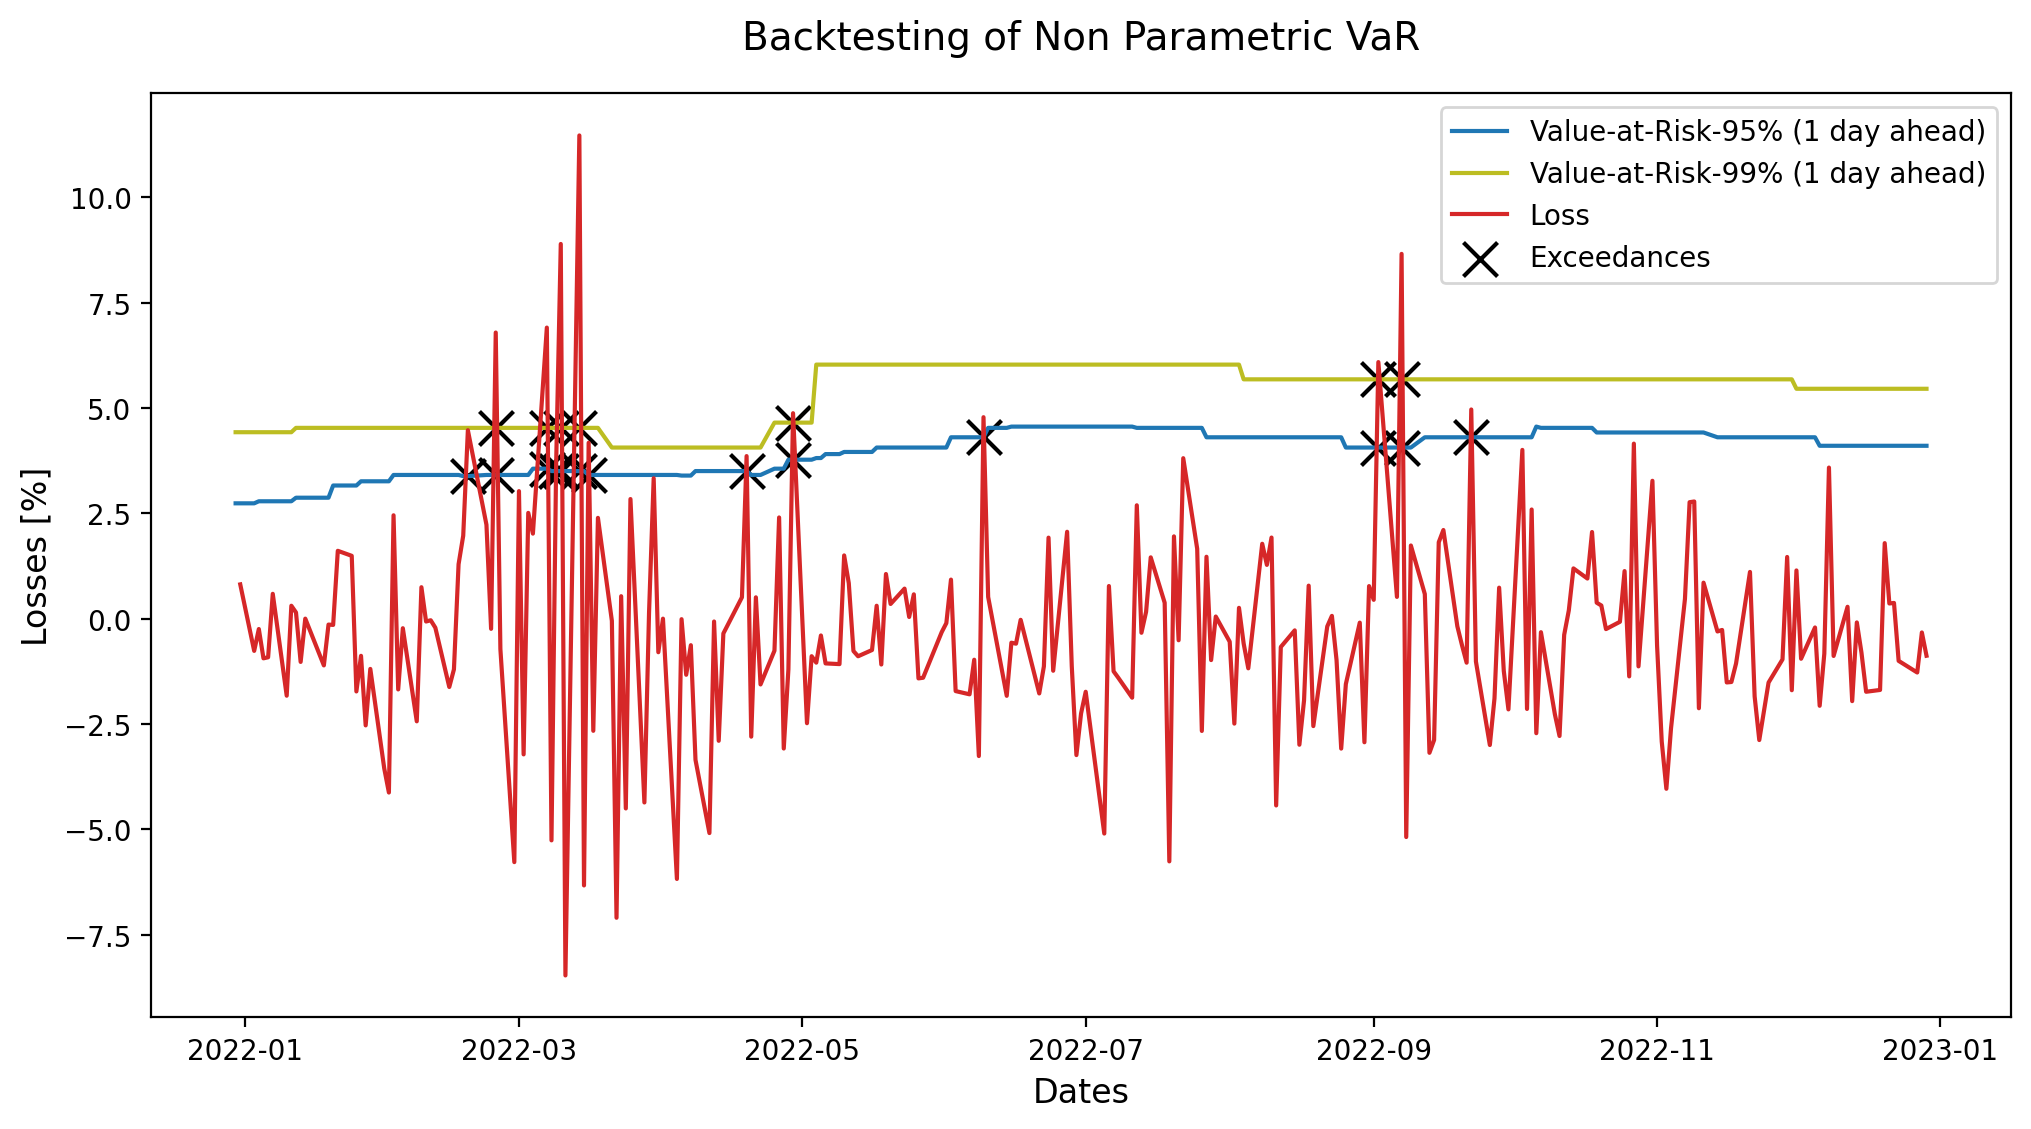

In [60]:
plotter("Backtesting of Non Parametric VaR")

## Backtesting Non Parametric Var Prob

In [61]:
for i in range(test_period):
    time = Base_offset+i
    
    Var_temp1,Es_temp1 = Non_parametric_VaR_prob(time,avg_price_returns,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Non_parametric_VaR_prob(time,avg_price_returns,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

Var_95_prediction for the last day is  4.105404830504011 %
ES_95_prediction for the last day is  43498.50328034522 $
Var_99_prediction for the last day is  5.458211198380713 %
ES_99_prediction for the last day is  38671.33702017679 $
No of exceedance for Var_95 is 13
No of exceedance for Var_99 is 7


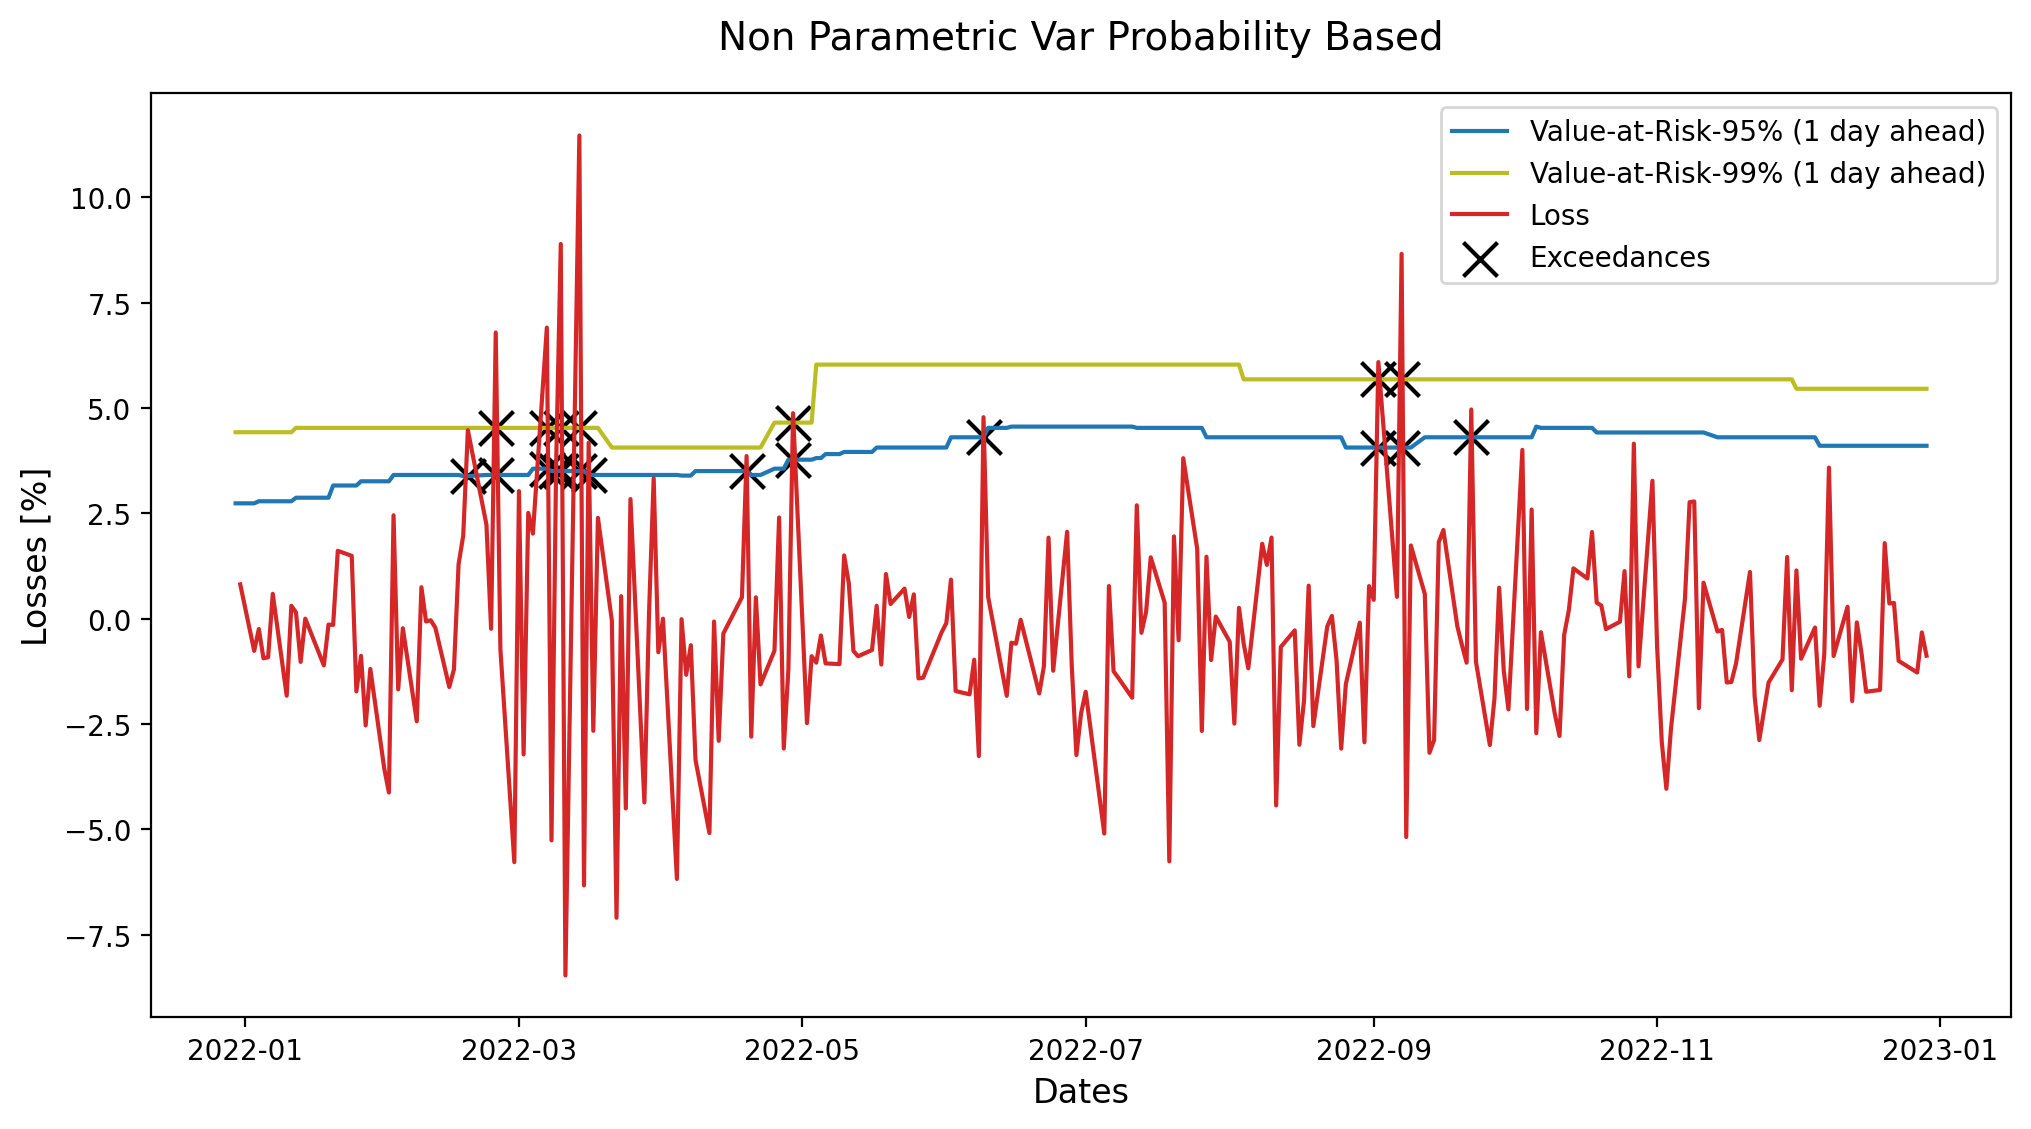

In [62]:
plotter("Non Parametric Var Probability Based")

## Backtesting for Non Parametric Var Volatility Based

In [63]:
lamda_par = 0.94
#Non_parametric_VaR_Vol(2517,return_arr/100,np.array(avg_price_returns).reshape(-1,1)/100,1,504,0.05,0.94)
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Non_parametric_VaR_Vol(time,return_arr,np.array(avg_price_returns).reshape(-1,1)/100,N,test_period,alpha1,lamda_par)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Non_parametric_VaR_Vol(time,return_arr,np.array(avg_price_returns).reshape(-1,1)/100,N,test_period,alpha2,lamda_par)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

C:\Users\Ferenc Fodor\AppData\Local\Temp\ipykernel_13232\4027132654.py:25: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  VaR =  -np.percentile(adj_ret, math.floor(alpha*100), interpolation='lower')


Var_95_prediction for the last day is  4.4470590549337965 %
ES_95_prediction for the last day is  5512.4016746781535 $
Var_99_prediction for the last day is  5.96125915909281 %
ES_99_prediction for the last day is  -33536.47760983615 $
No of exceedance for Var_95 is 8
No of exceedance for Var_99 is 5


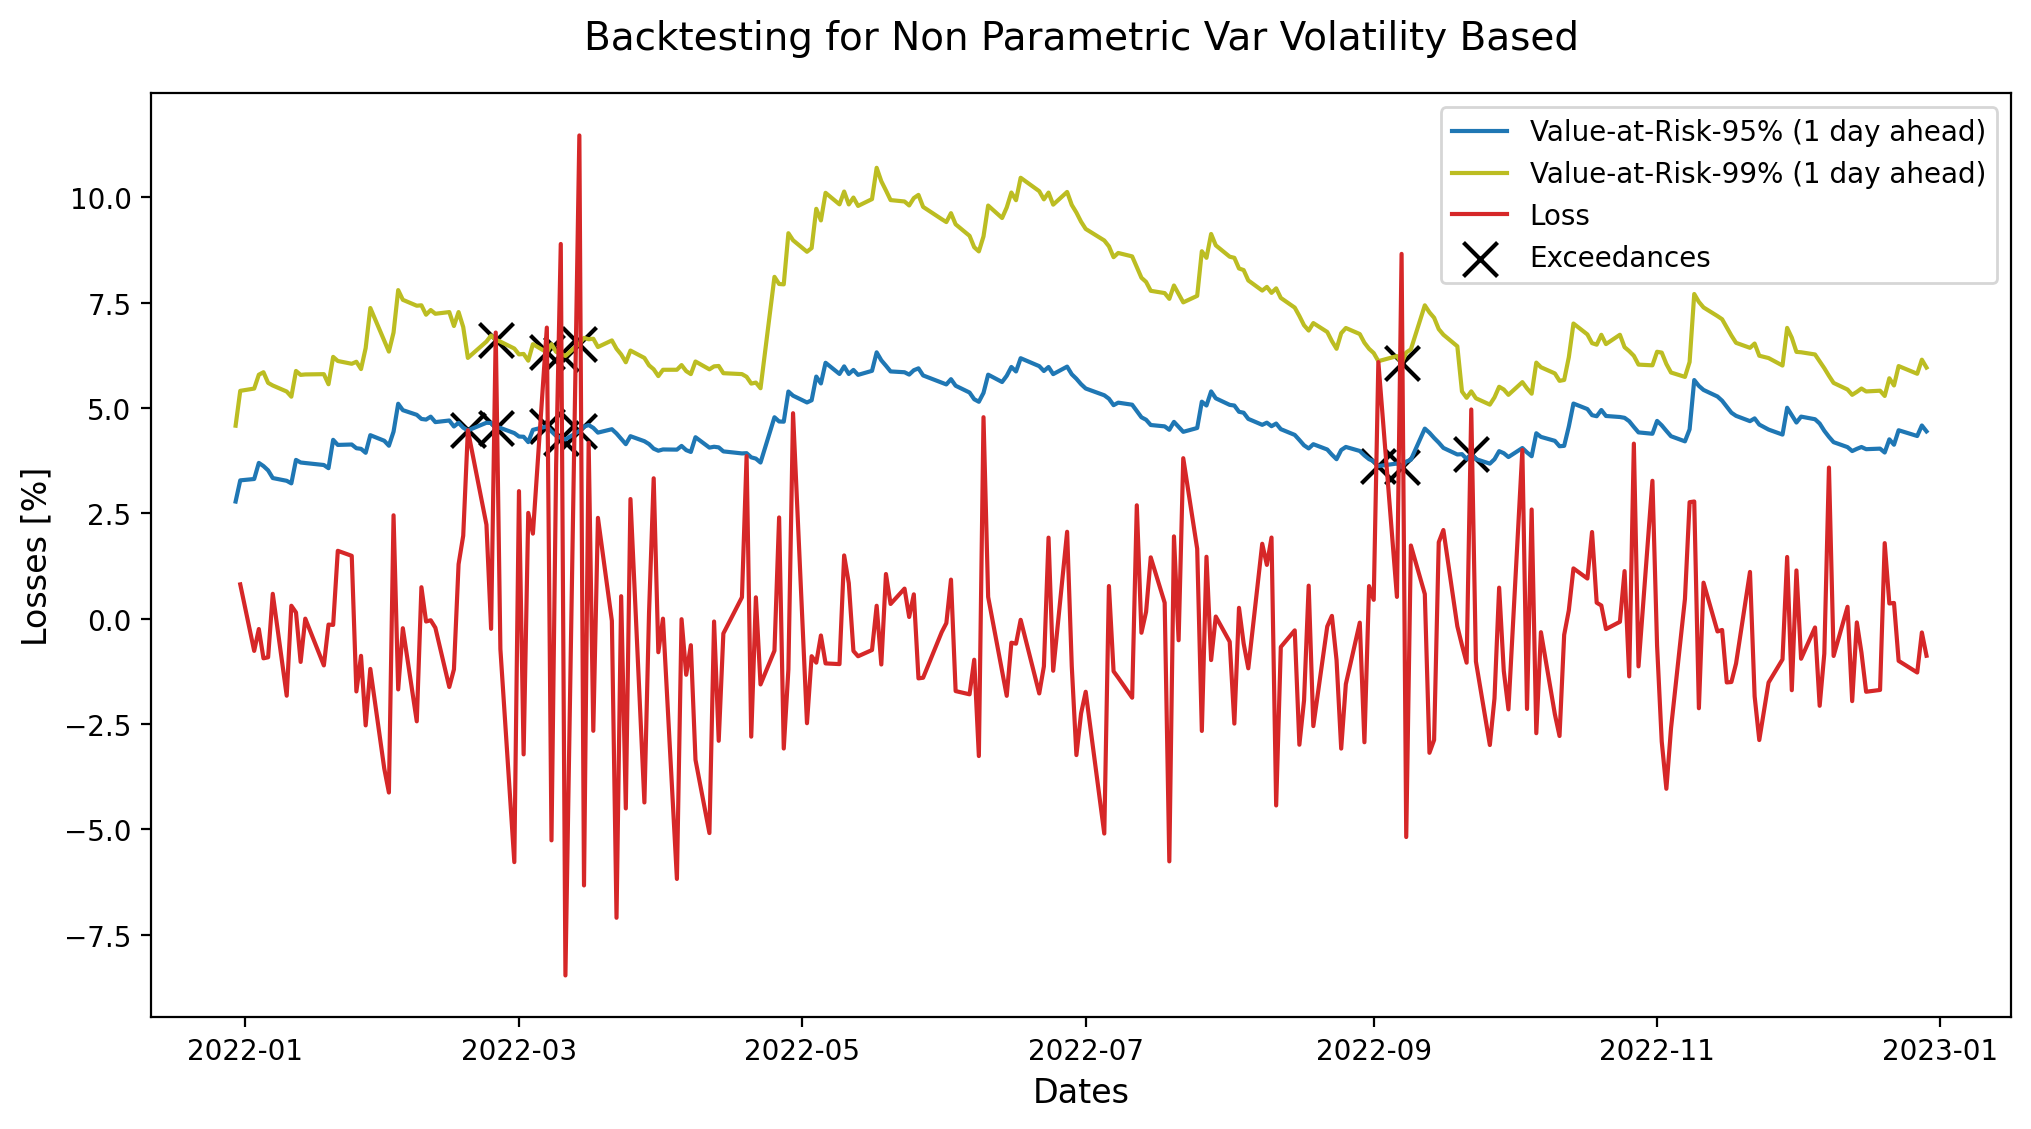

In [64]:
plotter("Backtesting for Non Parametric Var Volatility Based")

## Backtesting for Param_VaR_Normal_Singular

In [65]:
Param_VaR_Normal_Sing(2517,avg_price_returns,days=252,alpha = 0.05)
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Param_VaR_Normal_Sing(time,avg_price_returns,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Param_VaR_Normal_Sing(time,avg_price_returns,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Var_95_prediction for the last day is  4.102897623320424 %
ES_95_prediction for the last day is  51451.9914528814 $
Var_99_prediction for the last day is  5.802806406007505 %
ES_99_prediction for the last day is  66480.69415491658 $
No of exceedance for Var_95 is 18
No of exceedance for Var_99 is 9


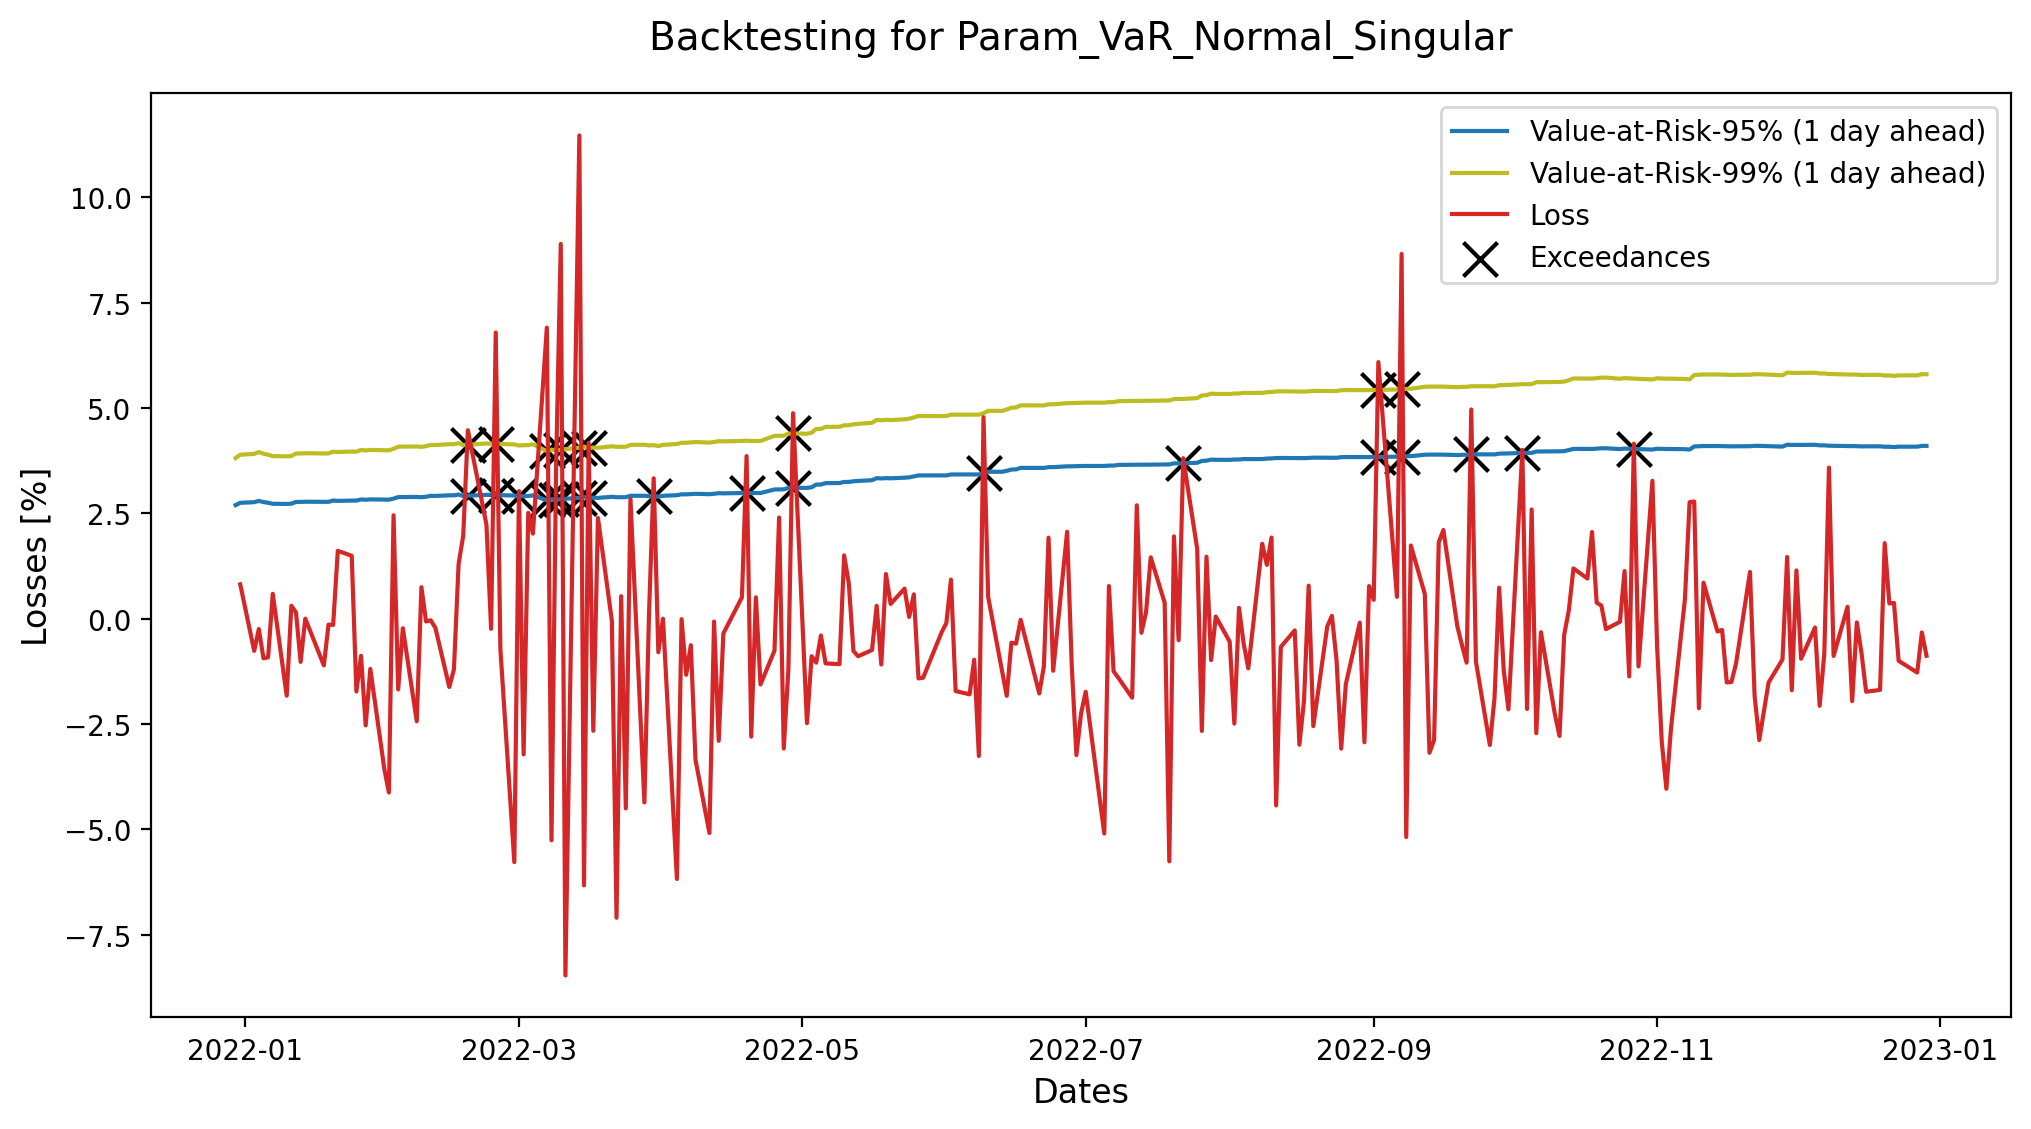

In [66]:
plotter("Backtesting for Param_VaR_Normal_Singular")

## Backtesting Param_VaR_Normal_Mult

In [67]:
Param_VaR_Normal_Mult(2517,return_arr,return_arr.shape[0])
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Param_VaR_Normal_Mult(time,return_arr,N,test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Param_VaR_Normal_Mult(time,return_arr,N,test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Ferenc Fodor\AppData\Local\Temp\ipykernel_13232\116208459.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  Cov_Mat = np.cov(return_arr[:,time-days:time])
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Var_95_prediction for the last day is  3.527820445345112 %
ES_95_prediction for the last day is  44240.29163425736 $
Var_99_prediction for the last day is  4.989463778753937 %
ES_99_prediction for the last day is  57162.516248856875 $
No of exceedance for Var_95 is 23
No of exceedance for Var_99 is 14


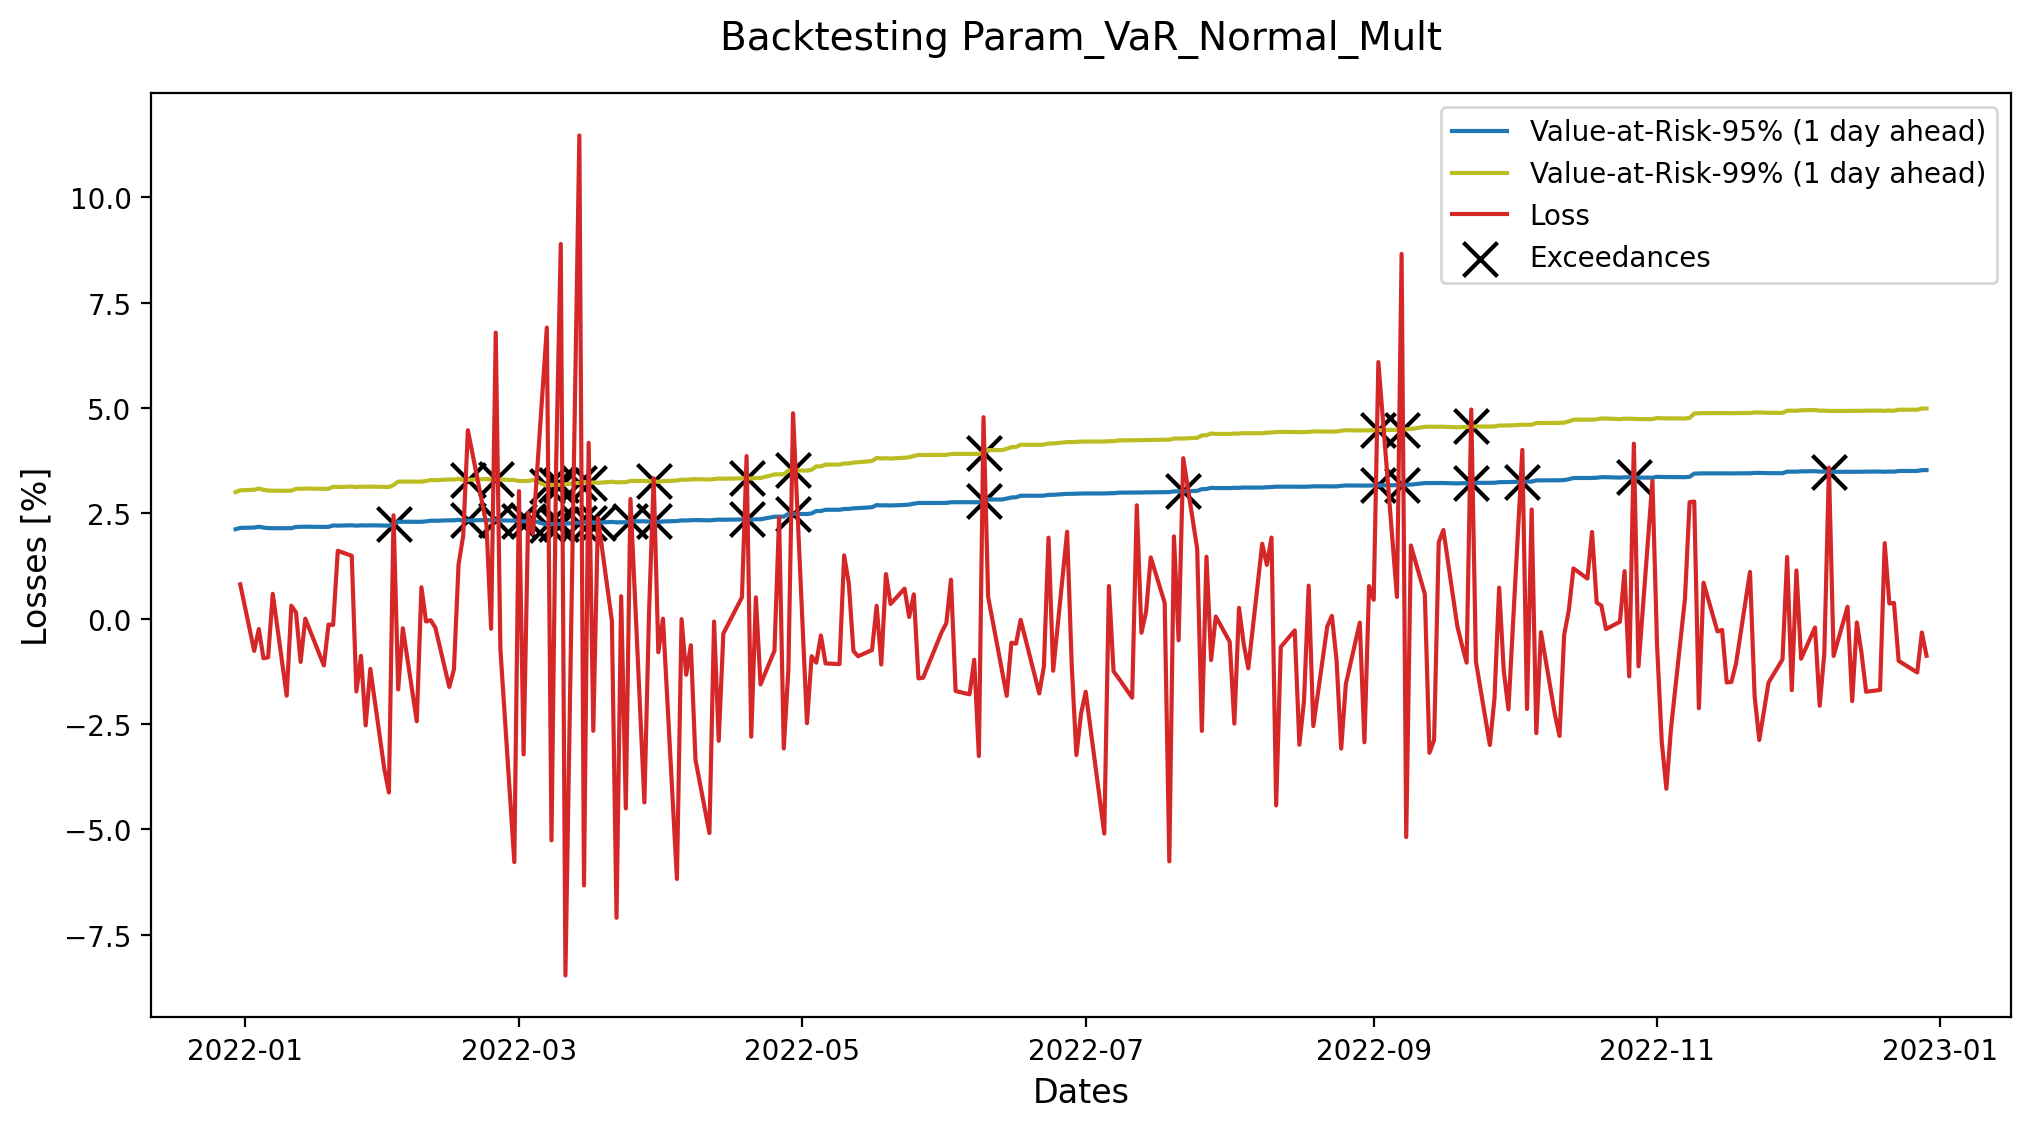

In [68]:
plotter("Backtesting Param_VaR_Normal_Mult")

## Backtesting for Parameterized EWMA

In [69]:
lamda_par = 0.95
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Param_EWMA(time,return_arr,N,test_period,alpha1,lamda_par)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Param_EWMA(time,return_arr,N,test_period,alpha2,lamda_par)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

Var_95_prediction for the last day is  3.3877641521224535 %
ES_95_prediction for the last day is  42483.92921350005 $
Var_99_prediction for the last day is  4.791379490495147 %
ES_99_prediction for the last day is  54893.134838683756 $
No of exceedance for Var_95 is 19
No of exceedance for Var_99 is 7


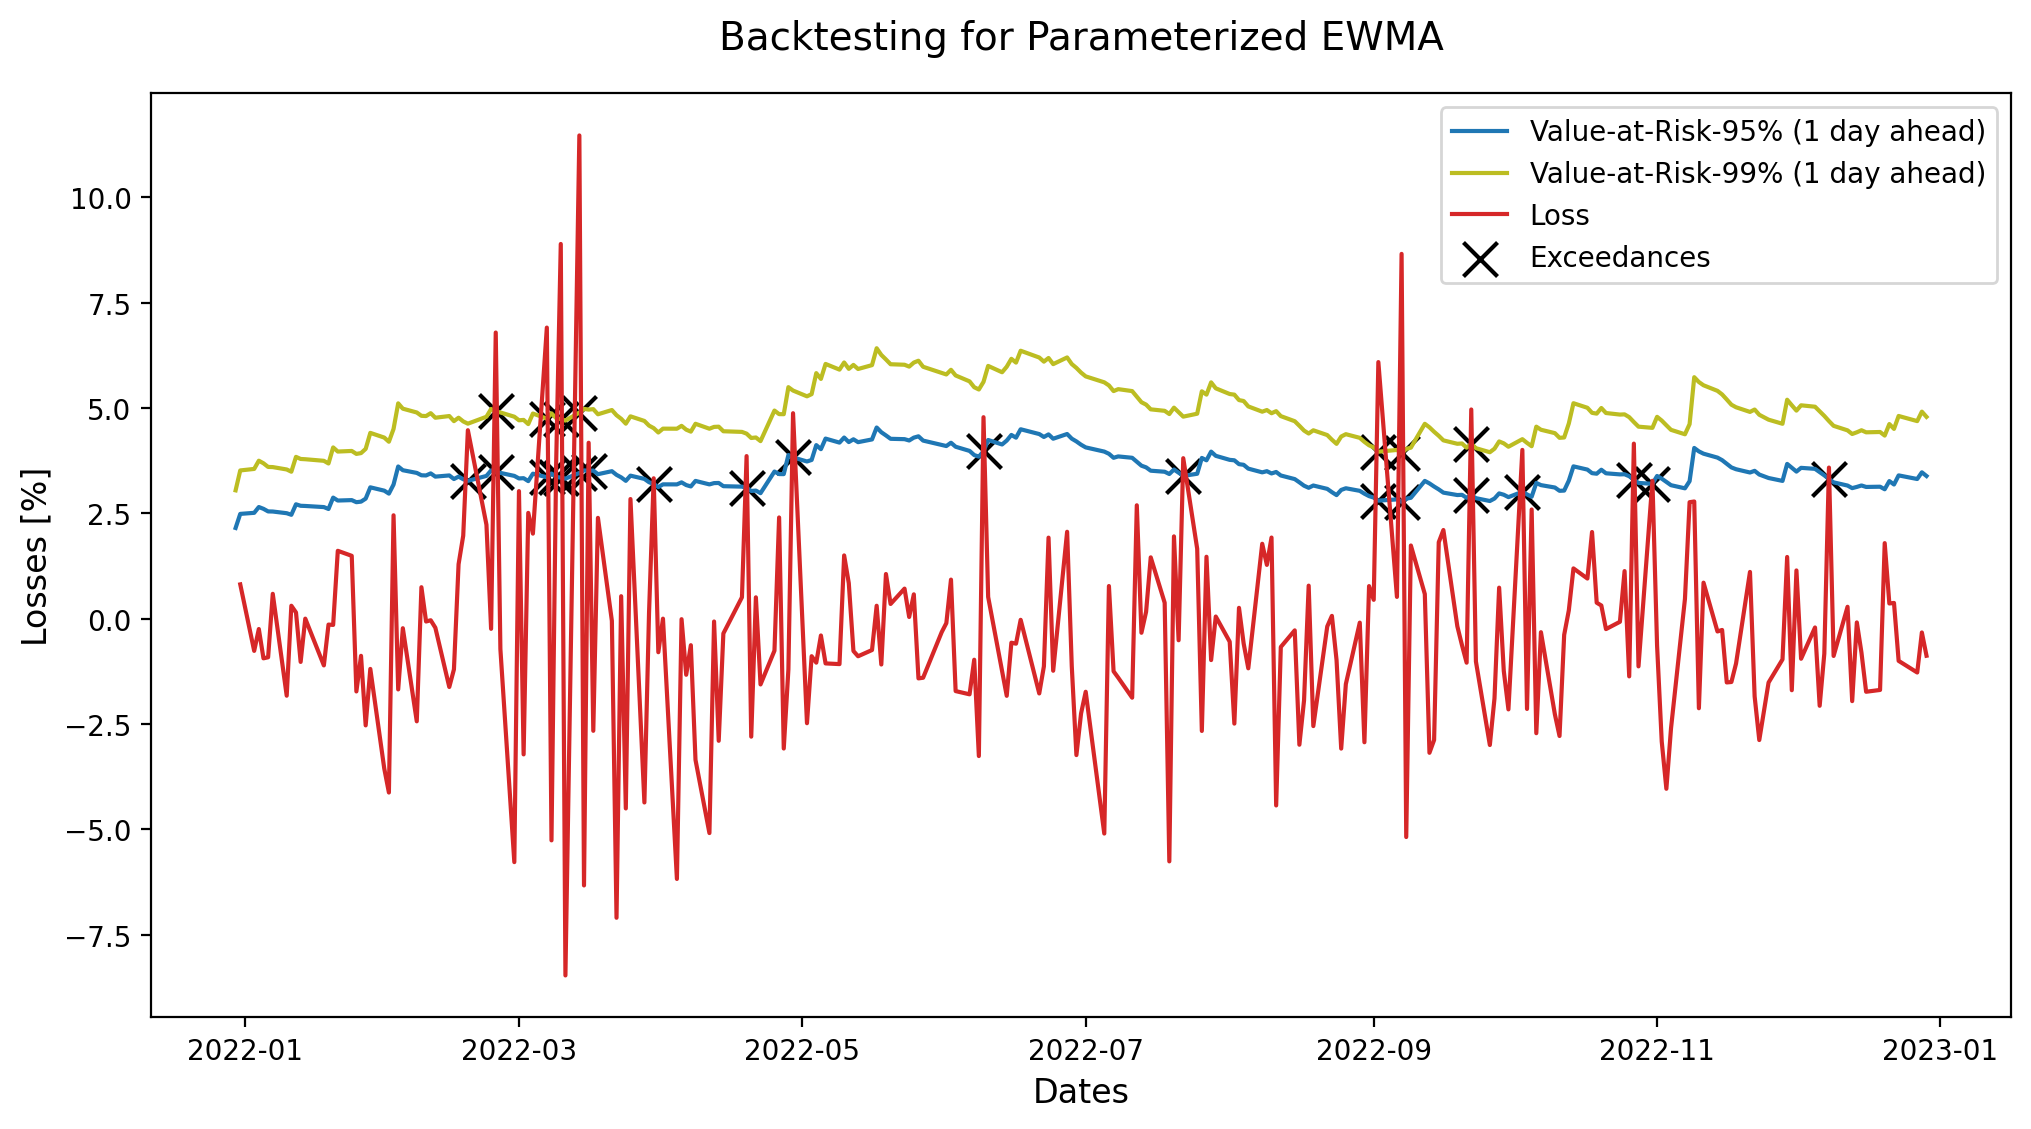

In [70]:
plotter("Backtesting for Parameterized EWMA")

## Backtesting for GARCH Model

In [30]:
for i in range(test_period):
    time = Base_offset+i
    Var_temp1,Es_temp1 = Garch_VaR(time,np.array(avg_price_returns),test_period,alpha1)
    VaR1[i] = Var_temp1
    ES1[i] = Es_temp1
    loss[i] = -avg_price_returns[i]
    exceedance1[i] = VaR1[i] < loss[i]
    
    Var_temp2,Es_temp2 = Garch_VaR(time,np.array(avg_price_returns),test_period,alpha2)
    VaR2[i] = Var_temp2
    ES2[i] = Es_temp2
    exceedance2[i] = VaR2[i] < loss[i]


c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002689. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002689. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12654403.935722532
Iteration:      2,   Func. Count:     17,   Neg. LLF: 367549.08209652075
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4027.8960972395244
Iteration:      4,   Func. Count:     38,   Neg. LLF: 678939.9257271426
Iteration:      5,   Func. Count:     49,   Neg. LLF: 7121.264282976174
Iteration:      6,   Func. Count:     59,   Neg. LLF: 1901150669.1794543
Iteration:      7,   Func. Count:     70,   Neg. LLF: 192870.9103754842
Iteration:      8,   Func. Count:     81,   Neg. LLF: 37111307.03851682
Iteration:      9,   Func. Count:     92,   Neg. LLF: 41751.338950710844
Iteration:     10,   Func. Count:    103,   Neg. LLF: 14680.761881106655
Iteration:     11,   Func. Count:    114,   Neg. LLF: 331664342.8667791
Iteration:     12,   Func. Count:    125,   Neg. LLF: 199518.05860940865
Iteration:     13,   Func. Count:    136,   Neg. LLF: 1751.150118617931
Optimization terminated successfully    (Exit mode 0)
   

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      6,   Func. Count:     58,   Neg. LLF: 23629.956040747304
Iteration:      7,   Func. Count:     69,   Neg. LLF: 34224.68077341337
Iteration:      8,   Func. Count:     80,   Neg. LLF: 310385239.64789474
Iteration:      9,   Func. Count:     91,   Neg. LLF: 16984.99074904071
Iteration:     10,   Func. Count:    102,   Neg. LLF: 1731.0034478583682
Iteration:     11,   Func. Count:    111,   Neg. LLF: 5445003.826945401
Iteration:     12,   Func. Count:    121,   Neg. LLF: -692.0317227074609
Optimization terminated successfully    (Exit mode 0)
            Current function value: -692.0317218778064
            Iterations: 16
            Function evaluations: 121
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 128102502158.16391
Iteration:      2,   Func. Count:     17,   Neg. LLF: 5389484.857777954
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2578517823.0518956
Optimization terminated successfully    (Exit mode 0)
         

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002753. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      6,   Func. Count:     52,   Neg. LLF: 511950944.2076042
Iteration:      7,   Func. Count:     63,   Neg. LLF: 163855181.4699844
Iteration:      8,   Func. Count:     74,   Neg. LLF: 16366089.67124958
Iteration:      9,   Func. Count:     84,   Neg. LLF: -691.0086324809156
Optimization terminated successfully    (Exit mode 0)
            Current function value: -691.0086320206742
            Iterations: 13
            Function evaluations: 84
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 94020224135.3176
Iteration:      2,   Func. Count:     17,   Neg. LLF: 986.2701010993101
Iteration:      3,   Func. Count:     26,   Neg. LLF: 28781739935.023224
Iteration:      4,   Func. Count:     37,   Neg. LLF: 102.90740482344488
Iteration:      5,   Func. Count:     46,   Neg. LLF: -658.5783133312642
Iteration:      6,   Func. Count:     52,   Neg. LLF: 511950944.2076042
Iteration:      7,   Func. Count:     63,   Neg. LLF: 163855181.4699

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002852. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002852. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     26,   Neg. LLF: 23018.671242117587
Iteration:      4,   Func. Count:     37,   Neg. LLF: 3833.3638685743613
Iteration:      5,   Func. Count:     47,   Neg. LLF: 1121929039.2191663
Iteration:      6,   Func. Count:     58,   Neg. LLF: 26971.035424780806
Iteration:      7,   Func. Count:     69,   Neg. LLF: 7384.191387354586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -690.4538929658663
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 186071030338.95636
Iteration:      2,   Func. Count:     17,   Neg. LLF: 32166.323262885333
Iteration:      3,   Func. Count:     26,   Neg. LLF: 23018.671242117587
Iteration:      4,   Func. Count:     37,   Neg. LLF: 3833.3638685743613
Iteration:      5,   Func. Count:     47,   Neg. LLF: 1121929039.2191663
Iteration:      6,   Func. Count:     58,   Neg. LLF: 26971.035

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002909. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002909. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     26,   Neg. LLF: 4777656.865188042
Iteration:      4,   Func. Count:     37,   Neg. LLF: -429.1640678255958
Iteration:      5,   Func. Count:     45,   Neg. LLF: 2905466.8644265174
Iteration:      6,   Func. Count:     56,   Neg. LLF: 75.77118175248116
Iteration:      7,   Func. Count:     66,   Neg. LLF: 248966.2001374116
Iteration:      8,   Func. Count:     77,   Neg. LLF: -596.874172721904
Iteration:      9,   Func. Count:     83,   Neg. LLF: -687.4076575182542
Iteration:     10,   Func. Count:     89,   Neg. LLF: -604.3246660900378
Iteration:     11,   Func. Count:     95,   Neg. LLF: -687.2274137459184
Iteration:     12,   Func. Count:    101,   Neg. LLF: -689.2412867685006
Iteration:     13,   Func. Count:    107,   Neg. LLF: -668.9494679148286
Iteration:     14,   Func. Count:    114,   Neg. LLF: -689.4708068235534
Iteration:     15,   Func. Count:    119,   Neg. LLF: -689.4754124889038
Iteration:     16,   Func. Count:    124,   Neg. LLF: -

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002907. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002907. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     28,   Neg. LLF: -588.8966621721534
Iteration:      4,   Func. Count:     34,   Neg. LLF: -686.5544305050747
Iteration:      5,   Func. Count:     40,   Neg. LLF: -603.0251100230862
Iteration:      6,   Func. Count:     46,   Neg. LLF: -686.3721068429838
Iteration:      7,   Func. Count:     52,   Neg. LLF: -688.4013662266616
Iteration:      8,   Func. Count:     58,   Neg. LLF: -656.5955473032233
Iteration:      9,   Func. Count:     66,   Neg. LLF: -688.6280497628571
Iteration:     10,   Func. Count:     71,   Neg. LLF: -688.6331972660278
Iteration:     11,   Func. Count:     76,   Neg. LLF: -688.6331705964843
Iteration:     12,   Func. Count:     83,   Neg. LLF: -688.6331641332563
Optimization terminated successfully    (Exit mode 0)
            Current function value: -688.6332016875652
            Iterations: 12
            Function evaluations: 93
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 137032

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002967. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002956. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 127505532.2762708
Iteration:      2,   Func. Count:     18,   Neg. LLF: 27655.075705716747
Iteration:      3,   Func. Count:     28,   Neg. LLF: 666.829226038151
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5419.870400938797
Iteration:      5,   Func. Count:     47,   Neg. LLF: -661.2493350733736
Iteration:      6,   Func. Count:     53,   Neg. LLF: -686.4330465020594
Iteration:      7,   Func. Count:     59,   Neg. LLF: -628.5506167704641
Iteration:      8,   Func. Count:     65,   Neg. LLF: -688.5748525602648
Iteration:      9,   Func. Count:     70,   Neg. LLF: -479.97875314351813
Iteration:     10,   Func. Count:     78,   Neg. LLF: -688.5095367620431
Iteration:     11,   Func. Count:     84,   Neg. LLF: -678.9601900478535
Iteration:     12,   Func. Count:     90,   Neg. LLF: -688.6695858364506
Iteration:     13,   Func. Count:     95,   Neg. LLF: -688.6695577602902
Optimization terminated successfully    (Exit mode 0)


c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fod

Iteration:      7,   Func. Count:     70,   Neg. LLF: 730015.2481563613
Iteration:      8,   Func. Count:     80,   Neg. LLF: -684.9438544870085
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.9438537470392
            Iterations: 12
            Function evaluations: 80
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 994718256.6999184
Iteration:      2,   Func. Count:     18,   Neg. LLF: 495.2590408065545
Iteration:      3,   Func. Count:     26,   Neg. LLF: 7247333.451429277
Iteration:      4,   Func. Count:     37,   Neg. LLF: 656018.4873484455
Iteration:      5,   Func. Count:     48,   Neg. LLF: 8013.176635568343
Iteration:      6,   Func. Count:     58,   Neg. LLF: 363918.93497841305
Iteration:      7,   Func. Count:     70,   Neg. LLF: 730015.2481563613
Iteration:      8,   Func. Count:     80,   Neg. LLF: -684.9438544870085
Optimization terminated successfully    (Exit mode 0)
            Cu

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\

Iteration:      1,   Func. Count:      6,   Neg. LLF: 141834543202.23413
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2083.699343766068
Iteration:      3,   Func. Count:     26,   Neg. LLF: -684.2065136002451
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.2065135622163
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 141834543202.23413
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2083.699343766068
Iteration:      3,   Func. Count:     26,   Neg. LLF: -684.2065136002451
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.2065135622163
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 113697488.99958028
Iteration:      2,   Func. Count:     17,   Neg. LLF: -683.501436376044
Opt

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000319. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 72564008.47710298
Iteration:      2,   Func. Count:     17,   Neg. LLF: 43899443.91260029
Iteration:      3,   Func. Count:     28,   Neg. LLF: 192806.0627598819
Iteration:      4,   Func. Count:     38,   Neg. LLF: -684.0219512120702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.0219510614627
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 72564008.47710298
Iteration:      2,   Func. Count:     17,   Neg. LLF: 43899443.91260029
Iteration:      3,   Func. Count:     28,   Neg. LLF: 192806.0627598819
Iteration:      4,   Func. Count:     38,   Neg. LLF: -684.0219512120702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.0219510614627
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iterat

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003134. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 98713307.52246025
Iteration:      2,   Func. Count:     17,   Neg. LLF: 92.87099471629904
Iteration:      3,   Func. Count:     27,   Neg. LLF: 402922.2183785544
Iteration:      4,   Func. Count:     37,   Neg. LLF: -640.4576766001741
Iteration:      5,   Func. Count:     43,   Neg. LLF: -689.6856683192268
Iteration:      6,   Func. Count:     49,   Neg. LLF: -576.7317403471518
Iteration:      7,   Func. Count:     56,   Neg. LLF: -687.949948659501
Iteration:      8,   Func. Count:     62,   Neg. LLF: -691.7999118924588
Iteration:      9,   Func. Count:     67,   Neg. LLF: -691.2621757913956
Iteration:     10,   Func. Count:     73,   Neg. LLF: -620.3268533529481
Iteration:     11,   Func. Count:     80,   Neg. LLF: -691.8492454700479
Iteration:     12,   Func. Count:     86,   Neg. LLF: -691.856985403619
Iteration:     13,   Func. Count:     91,   Neg. LLF: -691.8569998716534
Iteration:     14,   Func. Count:     95,   Neg. LLF: -6

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000295. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000295. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 799753671.170046
Iteration:      2,   Func. Count:     17,   Neg. LLF: 314990476.4797934
Iteration:      3,   Func. Count:     28,   Neg. LLF: 32029008.863925405
Iteration:      4,   Func. Count:     39,   Neg. LLF: -660.3559738976694
Iteration:      5,   Func. Count:     45,   Neg. LLF: 193788601.91362417
Iteration:      6,   Func. Count:     56,   Neg. LLF: 12370.580156214193
Iteration:      7,   Func. Count:     64,   Neg. LLF: -688.6885708960274
Optimization terminated successfully    (Exit mode 0)
            Current function value: -688.6885701503912
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 814631408.4291667
Iteration:      2,   Func. Count:     17,   Neg. LLF: 158609398.69292325
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3056.774463813775
Iteration:      4,   Func. Count:     38,   Neg. LLF: 9981553.0212

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fod

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4797441895.364715
Iteration:      2,   Func. Count:     17,   Neg. LLF: -654.4524075178394
Iteration:      3,   Func. Count:     23,   Neg. LLF: 21123854.31698069
Iteration:      4,   Func. Count:     34,   Neg. LLF: 5603646.070272172
Iteration:      5,   Func. Count:     45,   Neg. LLF: 224399.36245042505
Iteration:      6,   Func. Count:     57,   Neg. LLF: 1454497.0873898412
Iteration:      7,   Func. Count:     66,   Neg. LLF: -688.6235270010023
Optimization terminated successfully    (Exit mode 0)
            Current function value: -688.6235260978638
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4797441895.364715
Iteration:      2,   Func. Count:     17,   Neg. LLF: -654.4524075178394
Iteration:      3,   Func. Count:     23,   Neg. LLF: 21123854.31698069
Iteration:      4,   Func. Count:     34,   Neg. LLF: 5603646.0702

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fod

Iteration:      2,   Func. Count:     17,   Neg. LLF: 11960228.42895608
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1050179.2847071835
Iteration:      4,   Func. Count:     38,   Neg. LLF: -686.6274345104256
Optimization terminated successfully    (Exit mode 0)
            Current function value: -686.6274337134101
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32497023.39377267
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2550116.5518409857
Iteration:      3,   Func. Count:     27,   Neg. LLF: -684.541725739168
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.5417248592579
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 32497023.39377267
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2550116.5518409857
Iter

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 54887402.25281991
Iteration:      2,   Func. Count:     17,   Neg. LLF: 10887369.747980088
Iteration:      3,   Func. Count:     28,   Neg. LLF: 354660.29061840446
Iteration:      4,   Func. Count:     39,   Neg. LLF: -684.2727134154833
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.2727125979917
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 54887402.25281991
Iteration:      2,   Func. Count:     17,   Neg. LLF: 10887369.747980088
Iteration:      3,   Func. Count:     28,   Neg. LLF: 354660.29061840446
Iteration:      4,   Func. Count:     39,   Neg. LLF: -684.2727134154833
Optimization terminated successfully    (Exit mode 0)
            Current function value: -684.2727125979917
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4
It

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003236. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      2,   Func. Count:     17,   Neg. LLF: 14889.924021066538
Iteration:      3,   Func. Count:     26,   Neg. LLF: 560273.4499785748
Iteration:      4,   Func. Count:     36,   Neg. LLF: -682.3237664272405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -682.3237655223261
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 288092724.3087014
Iteration:      2,   Func. Count:     17,   Neg. LLF: 14889.924021066538
Iteration:      3,   Func. Count:     26,   Neg. LLF: 560273.4499785748
Iteration:      4,   Func. Count:     36,   Neg. LLF: -682.3237664272405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -682.3237655223261
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 211710994.89564842
Ite

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003291. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 764361165.1768444
Iteration:      2,   Func. Count:     17,   Neg. LLF: 13863.975540237578
Iteration:      3,   Func. Count:     25,   Neg. LLF: -679.8307794233408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -679.8307786875063
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 764361165.1768444
Iteration:      2,   Func. Count:     17,   Neg. LLF: 13863.975540237578
Iteration:      3,   Func. Count:     25,   Neg. LLF: -679.8307794233408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -679.8307786875063
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 327425311.1010772
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55381914.15407642
Iter

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003486. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     28,   Neg. LLF: 933978.0000372493
Iteration:      4,   Func. Count:     40,   Neg. LLF: 531.9106783892047
Iteration:      5,   Func. Count:     48,   Neg. LLF: 15870223.228814516
Iteration:      6,   Func. Count:     59,   Neg. LLF: 721072.6800858593
Iteration:      7,   Func. Count:     70,   Neg. LLF: -672.45915284029
Optimization terminated successfully    (Exit mode 0)
            Current function value: -672.4591515701118
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 475726501.2139858
Iteration:      2,   Func. Count:     17,   Neg. LLF: 57027620.57816105
Iteration:      3,   Func. Count:     28,   Neg. LLF: 933978.0000372493
Iteration:      4,   Func. Count:     40,   Neg. LLF: 531.9106783892047
Iteration:      5,   Func. Count:     48,   Neg. LLF: 15870223.228814516
Iteration:      6,   Func. Count:     59,   Neg. LLF: 721072.680085859

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003564. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 321098886.9005791
Iteration:      2,   Func. Count:     17,   Neg. LLF: 13268331.297849884
Iteration:      3,   Func. Count:     27,   Neg. LLF: -668.9577269999245
Optimization terminated successfully    (Exit mode 0)
            Current function value: -668.9577259041209
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 321098886.9005791
Iteration:      2,   Func. Count:     17,   Neg. LLF: 13268331.297849884
Iteration:      3,   Func. Count:     27,   Neg. LLF: -668.9577269999245
Optimization terminated successfully    (Exit mode 0)
            Current function value: -668.9577259041209
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 582119865.6110638
Iteration:      2,   Func. Count:     17,   Neg. LLF: 57637743.92239116
Iter

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1563078760.344475
Iteration:      2,   Func. Count:     17,   Neg. LLF: 526592707.7860605
Iteration:      3,   Func. Count:     28,   Neg. LLF: 531222.0174425064
Iteration:      4,   Func. Count:     39,   Neg. LLF: 7751639.877038683
Iteration:      5,   Func. Count:     49,   Neg. LLF: -664.9637196370178
Optimization terminated successfully    (Exit mode 0)
            Current function value: -664.9637183338258
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1563078760.344475
Iteration:      2,   Func. Count:     17,   Neg. LLF: 526592707.7860605
Iteration:      3,   Func. Count:     28,   Neg. LLF: 531222.0174425064
Iteration:      4,   Func. Count:     39,   Neg. LLF: 7751639.877038683
Iteration:      5,   Func. Count:     49,   Neg. LLF: -664.9637196370178
Optimization terminated successfully    (Exit mode 0)
            Curr

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      2,   Func. Count:     17,   Neg. LLF: 17862.95481040482
Iteration:      3,   Func. Count:     25,   Neg. LLF: 343126193.1432382
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1650999.7181979432
Iteration:      5,   Func. Count:     48,   Neg. LLF: 31437042155.579384
Iteration:      6,   Func. Count:     60,   Neg. LLF: -167.67558175149617
Iteration:      7,   Func. Count:     68,   Neg. LLF: 6888.57212327585
Iteration:      8,   Func. Count:     79,   Neg. LLF: 20597821.065686814
Iteration:      9,   Func. Count:     89,   Neg. LLF: -660.0785356751305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -660.0785344393773
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1503654972.8623264
Iteration:      2,   Func. Count:     17,   Neg. LLF: 67880.70556721692
Iteration:      3,   Func. Count:     27,   Neg. LLF: 63470783.55

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     27,   Neg. LLF: 240622423453.77625
Iteration:      4,   Func. Count:     38,   Neg. LLF: -654.8263143181741
Optimization terminated successfully    (Exit mode 0)
            Current function value: -654.8263129895997
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1494663153.6374068
Iteration:      2,   Func. Count:     17,   Neg. LLF: 33537.13357226253
Iteration:      3,   Func. Count:     27,   Neg. LLF: 240622423453.77625
Iteration:      4,   Func. Count:     38,   Neg. LLF: -654.8263143181741
Optimization terminated successfully    (Exit mode 0)
            Current function value: -654.8263129895997
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11941519048.671812
Iteration:      2,   Func. Count:     17,   Neg. LLF: 59371.89709806034
It

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004336. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1602431744.432212
Iteration:      2,   Func. Count:     17,   Neg. LLF: 415723168.36791885
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6147320.838013696
Iteration:      4,   Func. Count:     39,   Neg. LLF: 194276.33481351155
Iteration:      5,   Func. Count:     49,   Neg. LLF: -647.2767688885003
Optimization terminated successfully    (Exit mode 0)
            Current function value: -647.2767673984633
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1300261414.220156
Iteration:      2,   Func. Count:     17,   Neg. LLF: 207794473.31285778
Iteration:      3,   Func. Count:     27,   Neg. LLF: -645.2172527207974
Optimization terminated successfully    (Exit mode 0)
            Current function value: -645.2172512320631
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Ite

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 66987444.93124184
Iteration:      2,   Func. Count:     17,   Neg. LLF: 15679204.206002448
Iteration:      3,   Func. Count:     27,   Neg. LLF: -638.1740251594019
Optimization terminated successfully    (Exit mode 0)
            Current function value: -638.1740237725148
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 66987444.93124184
Iteration:      2,   Func. Count:     17,   Neg. LLF: 15679204.206002448
Iteration:      3,   Func. Count:     27,   Neg. LLF: -638.1740251594019
Optimization terminated successfully    (Exit mode 0)
            Current function value: -638.1740237725148
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 93875069.46608622
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4658436.901224397
Iter

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004786. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004786. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     29,   Neg. LLF: -633.5373879060052
Optimization terminated successfully    (Exit mode 0)
            Current function value: -633.5373865609704
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44795917.97110229
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1496687693.0540757
Iteration:      3,   Func. Count:     29,   Neg. LLF: -633.5373879060052
Optimization terminated successfully    (Exit mode 0)
            Current function value: -633.5373865609704
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 41918559.44073154
Iteration:      2,   Func. Count:     16,   Neg. LLF: -632.1054326613405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -632.1054313380334
            Iterations: 6
            F

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004862. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3638464380.5280857
Iteration:      2,   Func. Count:     16,   Neg. LLF: -625.4790746137951
Optimization terminated successfully    (Exit mode 0)
            Current function value: -625.4790735513722
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3638464380.5280857
Iteration:      2,   Func. Count:     16,   Neg. LLF: -625.4790746137951
Optimization terminated successfully    (Exit mode 0)
            Current function value: -625.4790735513722
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 45076281.96859476
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2041894.6829987934
Iteration:      3,   Func. Count:     28,   Neg. LLF: -625.4144363955163
Optimization terminated successfully    (Exit mode 0)
            Current 

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000496. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004961. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fod

Iteration:      2,   Func. Count:     16,   Neg. LLF: -615.7262253513766
Optimization terminated successfully    (Exit mode 0)
            Current function value: -615.7262233769811
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1925456429.1902921
Iteration:      2,   Func. Count:     16,   Neg. LLF: -615.7262253513766
Optimization terminated successfully    (Exit mode 0)
            Current function value: -615.7262233769811
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 127222669.94709507
Iteration:      2,   Func. Count:     16,   Neg. LLF: -615.4711933488545
Optimization terminated successfully    (Exit mode 0)
            Current function value: -615.4711913990028
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Iteration: 

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005258. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      5,   Func. Count:     47,   Neg. LLF: 285618254.83876884
Optimization terminated successfully    (Exit mode 0)
            Current function value: -608.972296507216
            Iterations: 6
            Function evaluations: 57
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      6,   Neg. LLF: 87033909.60225855
Iteration:      2,   Func. Count:     17,   Neg. LLF: -273.63242578494686
Iteration:      3,   Func. Count:     23,   Neg. LLF: 21007510.61657188
Iteration:      4,   Func. Count:     34,   Neg. LLF: 913.892317419375
Iteration:      5,   Func. Count:     43,   Neg. LLF: 116.59776124309792
Iteration:      6,   Func. Count:     53,   Neg. LLF: -606.1576096848582
Iteration:      7,   Func. Count:     59,   Neg. LLF: -609.9053507099892
Iteration:      8,   Func. Count:     64,   Neg. LLF: -607.5891933847137
Iteration:      9,   Func. Count:     70,   Neg. LLF: -142.77343826260758
Iteration:     10,   Func. Count:     78,   Neg. LLF: -609.528922

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      5,   Func. Count:     40,   Neg. LLF: -260.612824181242
Iteration:      6,   Func. Count:     48,   Neg. LLF: -607.7693016858459
Iteration:      7,   Func. Count:     54,   Neg. LLF: -608.7716411300936
Iteration:      8,   Func. Count:     60,   Neg. LLF: -608.7495280714305
Iteration:      9,   Func. Count:     66,   Neg. LLF: -605.8418573351304
Iteration:     10,   Func. Count:     72,   Neg. LLF: -609.1647929712726
Iteration:     11,   Func. Count:     78,   Neg. LLF: -609.0378249404189
Iteration:     12,   Func. Count:     84,   Neg. LLF: -609.1821245424376
Iteration:     13,   Func. Count:     88,   Neg. LLF: -609.1821245422542
Optimization terminated successfully    (Exit mode 0)
            Current function value: -609.1821245424376
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 35416166.41757624
Iteration:      2,   Func. Count:     17,   Neg. LLF: 122.1153

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 209666171922.88446
Iteration:      2,   Func. Count:     17,   Neg. LLF: 74537.69617642008
Iteration:      3,   Func. Count:     26,   Neg. LLF: 102473.87761876555
Iteration:      4,   Func. Count:     37,   Neg. LLF: 700.6448661913826
Iteration:      5,   Func. Count:     46,   Neg. LLF: 17727.611251189956
Iteration:      6,   Func. Count:     56,   Neg. LLF: -598.1162884545029
Iteration:      7,   Func. Count:     62,   Neg. LLF: -579.0449891404005
Iteration:      8,   Func. Count:     68,   Neg. LLF: -601.3304771822792
Iteration:      9,   Func. Count:     74,   Neg. LLF: -605.9407526068571
Iteration:     10,   Func. Count:     80,   Neg. LLF: -605.6240214213633
Iteration:     11,   Func. Count:     86,   Neg. LLF: -606.0827424976975
Iteration:     12,   Func. Count:     92,   Neg. LLF: -606.1691137531925
Iteration:     13,   Func. Count:     98,   Neg. LLF: -606.9386869981925
Iteration:     14,   Func. Count:    104,   Neg. LLF:

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 244222162668.15222
Iteration:      2,   Func. Count:     17,   Neg. LLF: 6938.668641724368
Iteration:      3,   Func. Count:     26,   Neg. LLF: 37516487889.29535
Iteration:      4,   Func. Count:     37,   Neg. LLF: 147.28341755249897
Iteration:      5,   Func. Count:     46,   Neg. LLF: -589.569064905786
Iteration:      6,   Func. Count:     52,   Neg. LLF: -340.12561594636594
Iteration:      7,   Func. Count:     58,   Neg. LLF: -581.8152603306345
Iteration:      8,   Func. Count:     64,   Neg. LLF: -368.471957478745
Iteration:      9,   Func. Count:     70,   Neg. LLF: -602.2135223809928
Iteration:     10,   Func. Count:     76,   Neg. LLF: -602.7444035105455
Iteration:     11,   Func. Count:     82,   Neg. LLF: -593.3262781765701
Iteration:     12,   Func. Count:     88,   Neg. LLF: -603.3244398816121
Iteration:     13,   Func. Count:     94,   Neg. LLF: -603.5791612477512
Iteration:     14,   Func. Count:    100,   Neg. LLF: 

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:     12,   Func. Count:     96,   Neg. LLF: -602.1235302696186
Iteration:     13,   Func. Count:    101,   Neg. LLF: -602.1234954383897
Optimization terminated successfully    (Exit mode 0)
            Current function value: -602.1235302695486
            Iterations: 14
            Function evaluations: 111
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7445207.043895014
Iteration:      2,   Func. Count:     17,   Neg. LLF: 376.30645232646464
Iteration:      3,   Func. Count:     26,   Neg. LLF: 48501.18186433571
Iteration:      4,   Func. Count:     36,   Neg. LLF: -586.1285529299676
Iteration:      5,   Func. Count:     42,   Neg. LLF: 205842.98843256923
Iteration:      6,   Func. Count:     49,   Neg. LLF: -579.0414450699157
Iteration:      7,   Func. Count:     55,   Neg. LLF: -599.6927959290513
Iteration:      8,   Func. Count:     61,   Neg. LLF: -600.5453237169993
Iteration:      9,   Func. Count:     67,   Neg. LLF: -597.54

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodo

Iteration:      6,   Func. Count:     53,   Neg. LLF: 542987.7598904836
Iteration:      7,   Func. Count:     60,   Neg. LLF: -574.9008709880765
Iteration:      8,   Func. Count:     66,   Neg. LLF: -595.4343665559418
Iteration:      9,   Func. Count:     72,   Neg. LLF: -595.329625591926
Iteration:     10,   Func. Count:     78,   Neg. LLF: -598.4747505366807
Iteration:     11,   Func. Count:     84,   Neg. LLF: -598.6397690624257
Iteration:     12,   Func. Count:     90,   Neg. LLF: -598.651650787181
Iteration:     13,   Func. Count:     95,   Neg. LLF: -598.651699441313
Iteration:     14,   Func. Count:    100,   Neg. LLF: -598.6516989106112
Optimization terminated successfully    (Exit mode 0)
            Current function value: -598.6516994413481
            Iterations: 15
            Function evaluations: 110
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 69062926444.09448
Iteration:      2,   Func. Count:     17,   Neg. LLF: 402129620.

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005601. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 86056811.39814794
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1431128.0533340622
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1111501.9731074024
Iteration:      4,   Func. Count:     40,   Neg. LLF: 18393.38262146285
Iteration:      5,   Func. Count:     50,   Neg. LLF: 38708.6877880048
Iteration:      6,   Func. Count:     60,   Neg. LLF: 1440526.9104881724
Iteration:      7,   Func. Count:     70,   Neg. LLF: -591.6605883062177
Optimization terminated successfully    (Exit mode 0)
            Current function value: -591.6605844908102
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 86056811.39814794
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1431128.0533340622
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1111501.9731074024
Iteration:      4,   Func. Count:     40,   Neg. LLF: 18393.382621

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005581. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005597. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      7,   Func. Count:     68,   Neg. LLF: 9999.158786380605
Iteration:      8,   Func. Count:     75,   Neg. LLF: -533.3401947577235
Iteration:      9,   Func. Count:     82,   Neg. LLF: -589.8431265930712
Iteration:     10,   Func. Count:     88,   Neg. LLF: -591.5920792374947
Iteration:     11,   Func. Count:     94,   Neg. LLF: -586.3103417382218
Iteration:     12,   Func. Count:    101,   Neg. LLF: -591.4089926845625
Iteration:     13,   Func. Count:    108,   Neg. LLF: -593.2245927960778
Iteration:     14,   Func. Count:    113,   Neg. LLF: -593.2247985707079
Iteration:     15,   Func. Count:    118,   Neg. LLF: -593.2248054652623
Iteration:     16,   Func. Count:    122,   Neg. LLF: -593.2248054651749
Optimization terminated successfully    (Exit mode 0)
            Current function value: -593.2248054652623
            Iterations: 18
            Function evaluations: 122
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      6,   Neg. LLF: 176541

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005629. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005626. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     28,   Neg. LLF: 370793.34867405205
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3044.3616464766683
Iteration:      5,   Func. Count:     47,   Neg. LLF: 470782.105122418
Iteration:      6,   Func. Count:     57,   Neg. LLF: 524104.60999814444
Iteration:      7,   Func. Count:     68,   Neg. LLF: 2830.8775531387737
Iteration:      8,   Func. Count:     77,   Neg. LLF: 9665.265396866162
Iteration:      9,   Func. Count:     87,   Neg. LLF: 354.1229867718354
Iteration:     10,   Func. Count:     96,   Neg. LLF: 2105.983788801859
Iteration:     11,   Func. Count:    104,   Neg. LLF: 59.758771215877196
Iteration:     12,   Func. Count:    112,   Neg. LLF: -588.2122146539588
Iteration:     13,   Func. Count:    118,   Neg. LLF: -581.8555805431772
Iteration:     14,   Func. Count:    124,   Neg. LLF: -590.3474260912174
Iteration:     15,   Func. Count:    130,   Neg. LLF: -591.9203959111693
Iteration:     16,   Func. Count:    135,   Neg. LLF: -5

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:     13,   Func. Count:    117,   Neg. LLF: -587.8199189149868
Optimization terminated successfully    (Exit mode 0)
            Current function value: -587.8199882576068
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 145675095.5713095
Iteration:      2,   Func. Count:     17,   Neg. LLF: 37946.92066443861
Iteration:      3,   Func. Count:     27,   Neg. LLF: 32530549.6950503
Iteration:      4,   Func. Count:     38,   Neg. LLF: 231473181.83898696
Iteration:      5,   Func. Count:     51,   Neg. LLF: 1025699757.2682076
Iteration:      6,   Func. Count:     64,   Neg. LLF: 576750712.4487993
Optimization terminated successfully    (Exit mode 0)
            Current function value: -586.8853159279515
            Iterations: 7
            Function evaluations: 74
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 145675095.5713095
Ite

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005823. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2424993.5492820367
Iteration:      2,   Func. Count:     17,   Neg. LLF: 883746.7318738404
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6920952.47087253
Iteration:      4,   Func. Count:     40,   Neg. LLF: 191048.51601548016
Iteration:      5,   Func. Count:     50,   Neg. LLF: 15294334.494112456
Iteration:      6,   Func. Count:     61,   Neg. LLF: 9279806.346539019
Iteration:      7,   Func. Count:     73,   Neg. LLF: 18049473.445951372
Iteration:      8,   Func. Count:     85,   Neg. LLF: 28343274.17937319
Iteration:      9,   Func. Count:     97,   Neg. LLF: 86220346.62423395
Iteration:     10,   Func. Count:    109,   Neg. LLF: 366.28436407087327
Iteration:     11,   Func. Count:    119,   Neg. LLF: 151047.5876192899
Iteration:     12,   Func. Count:    130,   Neg. LLF: 1494.5735536341044
Iteration:     13,   Func. Count:    137,   Neg. LLF: -579.8550292598442
Iteration:     14,   Func. Count:    147,   Neg. LLF: -575

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005854. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005922. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      2,   Func. Count:     17,   Neg. LLF: 25935658918.966934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -578.3849431952417
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11019908.111110855
Iteration:      2,   Func. Count:     17,   Neg. LLF: 25935658918.966934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -578.3849431952417
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7574061.051381707
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2811674.9422414675
Optimization terminated successfully    (Exit mode 0)
            Current function value: -577.7039973973251
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:  

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4590598.142809083
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4796869490.874705
Optimization terminated successfully    (Exit mode 0)
            Current function value: -577.8534976011047
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2774951.965520505
Iteration:      2,   Func. Count:     17,   Neg. LLF: 884552393.0300138
Optimization terminated successfully    (Exit mode 0)
            Current function value: -578.146640353687
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2774951.965520505
Iteration:      2,   Func. Count:     17,   Neg. LLF: 884552393.0300138
Optimization terminated successfully    (Exit mode 0)
            Current function value: -578.146640353687
            Iterations: 2
            Functio

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005991. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005961. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      3,   Func. Count:     29,   Neg. LLF: 142576.97196106793
Iteration:      4,   Func. Count:     39,   Neg. LLF: 9807286574.132433
Iteration:      5,   Func. Count:     51,   Neg. LLF: 9708006.434708491
Iteration:      6,   Func. Count:     62,   Neg. LLF: 45166.51085818288
Iteration:      7,   Func. Count:     72,   Neg. LLF: 14560178.03472903
Iteration:      8,   Func. Count:     83,   Neg. LLF: 14.808250424531074
Iteration:      9,   Func. Count:     91,   Neg. LLF: 11444565.405597635
Iteration:     10,   Func. Count:    101,   Neg. LLF: -578.118261630966
Optimization terminated successfully    (Exit mode 0)
            Current function value: -578.1182597624553
            Iterations: 14
            Function evaluations: 101
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3099.8041555812547
Iteration:      2,   Func. Count:     16,   Neg. LLF: 324921488.4075991
Iteration:      3,   Func. Count:     29,   Neg. LLF: 142576.9719

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:     10,   Func. Count:    105,   Neg. LLF: 808.2910020639706
Iteration:     11,   Func. Count:    113,   Neg. LLF: -578.2476216158886
Optimization terminated successfully    (Exit mode 0)
            Current function value: -578.2476204671307
            Iterations: 15
            Function evaluations: 113
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34637.41954720397
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6070183.820493831
Iteration:      3,   Func. Count:     27,   Neg. LLF: 28210.413694457293
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3193.783343450597
Iteration:      5,   Func. Count:     48,   Neg. LLF: 1155915.6509519883
Iteration:      6,   Func. Count:     59,   Neg. LLF: 36970.017020770625
Iteration:      7,   Func. Count:     70,   Neg. LLF: 76.23836707534466
Iteration:      8,   Func. Count:     78,   Neg. LLF: 14133359.890487889
Iteration:      9,   Func. Count:     89,   Neg. LLF: -387.50845

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005962. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005962. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      2,   Func. Count:     17,   Neg. LLF: 23160.299747871777
Iteration:      3,   Func. Count:     24,   Neg. LLF: -384.39937967306173
Iteration:      4,   Func. Count:     33,   Neg. LLF: -571.0663553438508
Iteration:      5,   Func. Count:     39,   Neg. LLF: 11395913.958790436
Iteration:      6,   Func. Count:     50,   Neg. LLF: 140459468.97917867
Iteration:      7,   Func. Count:     58,   Neg. LLF: -574.5758348436345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -574.5758348292861
            Iterations: 11
            Function evaluations: 58
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 114250.72803931413
Iteration:      2,   Func. Count:     17,   Neg. LLF: -120.64005539428695
Iteration:      3,   Func. Count:     25,   Neg. LLF: -261.5256943988537
Iteration:      4,   Func. Count:     34,   Neg. LLF: 711.3217331777046
Iteration:      5,   Func. Count:     42,   Neg. LLF: -569.8

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:     10,   Func. Count:     70,   Neg. LLF: -573.9467905657252
Iteration:     11,   Func. Count:     76,   Neg. LLF: -574.1440510002959
Iteration:     12,   Func. Count:     82,   Neg. LLF: -574.1504019245775
Iteration:     13,   Func. Count:     87,   Neg. LLF: -574.15060648637
Iteration:     14,   Func. Count:     92,   Neg. LLF: -574.1506534158335
Iteration:     15,   Func. Count:     97,   Neg. LLF: -574.1506330357101
Optimization terminated successfully    (Exit mode 0)
            Current function value: -574.1506534158336
            Iterations: 15
            Function evaluations: 106
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      6,   Neg. LLF: 110102531.33404092
Iteration:      2,   Func. Count:     17,   Neg. LLF: 103.63871615977473
Iteration:      3,   Func. Count:     26,   Neg. LLF: -570.505671614844
Iteration:      4,   Func. Count:     32,   Neg. LLF: -509.2523779655095
Iteration:      5,   Func. Count:     40,   Neg. LLF: -571.707

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      7,   Func. Count:     51,   Neg. LLF: -569.5237281977999
Iteration:      8,   Func. Count:     57,   Neg. LLF: -552.7870959708725
Iteration:      9,   Func. Count:     63,   Neg. LLF: -571.327026568719
Iteration:     10,   Func. Count:     69,   Neg. LLF: -573.8804440916404
Iteration:     11,   Func. Count:     75,   Neg. LLF: -573.9341522854834
Iteration:     12,   Func. Count:     80,   Neg. LLF: -573.938774852228
Iteration:     13,   Func. Count:     85,   Neg. LLF: -573.9433082949963
Iteration:     14,   Func. Count:     90,   Neg. LLF: -573.9434539219247
Iteration:     15,   Func. Count:     95,   Neg. LLF: -573.9435519816625
Iteration:     16,   Func. Count:    100,   Neg. LLF: -573.9435259977829
Optimization terminated successfully    (Exit mode 0)
            Current function value: -573.943551981466
            Iterations: 16
            Function evaluations: 110
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      6,   Neg. LLF: 285.1528

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006225. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006225. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      2,   Func. Count:     17,   Neg. LLF: 202.15356920766632
Iteration:      3,   Func. Count:     26,   Neg. LLF: -548.0963941496733
Iteration:      4,   Func. Count:     33,   Neg. LLF: -571.4084189762075
Iteration:      5,   Func. Count:     39,   Neg. LLF: 109.84215520591583
Iteration:      6,   Func. Count:     48,   Neg. LLF: -571.4101660688889
Iteration:      7,   Func. Count:     54,   Neg. LLF: -571.3334393747587
Iteration:      8,   Func. Count:     60,   Neg. LLF: -570.0737205386168
Iteration:      9,   Func. Count:     66,   Neg. LLF: -567.7552849122076
Iteration:     10,   Func. Count:     72,   Neg. LLF: -571.1295181074522
Iteration:     11,   Func. Count:     78,   Neg. LLF: -572.8437229222734
Iteration:     12,   Func. Count:     84,   Neg. LLF: -572.8693766792753
Iteration:     13,   Func. Count:     90,   Neg. LLF: -572.8711559133735
Iteration:     14,   Func. Count:     95,   Neg. LLF: -572.8725969177638
Iteration:     15,   Func. Count:    100,   Neg. LL

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      6,   Neg. LLF: 125447.80837387092
Iteration:      2,   Func. Count:     17,   Neg. LLF: 104.43453003750182
Iteration:      3,   Func. Count:     26,   Neg. LLF: -569.9594367981251
Iteration:      4,   Func. Count:     32,   Neg. LLF: -569.535612089462
Iteration:      5,   Func. Count:     38,   Neg. LLF: -569.7353609382405
Iteration:      6,   Func. Count:     44,   Neg. LLF: -553.0005151324387
Iteration:      7,   Func. Count:     50,   Neg. LLF: -569.4367603882789
Iteration:      8,   Func. Count:     56,   Neg. LLF: -570.5874980607184
Iteration:      9,   Func. Count:     62,   Neg. LLF: -571.3771767340277
Iteration:     10,   Func. Count:     68,   Neg. LLF: -571.4229788712103
Iteration:     11,   Func. Count:     74,   Neg. LLF: -571.4276902769809
Optimization terminated successfully    (Exit mode 0)
            Current function value: -571.4282514819392
            Iterations: 11
            Function evaluations: 81
            Gradient eval

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      7,   Func. Count:     50,   Neg. LLF: -571.6869613060219
Iteration:      8,   Func. Count:     56,   Neg. LLF: -572.4704077691713
Iteration:      9,   Func. Count:     62,   Neg. LLF: -572.5252077044524
Iteration:     10,   Func. Count:     68,   Neg. LLF: -572.613483804982
Iteration:     11,   Func. Count:     74,   Neg. LLF: -572.6229409182715
Optimization terminated successfully    (Exit mode 0)
            Current function value: -572.6239328430908
            Iterations: 11
            Function evaluations: 84
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 155530.90474337104
Iteration:      2,   Func. Count:     17,   Neg. LLF: 171.02473887467391
Iteration:      3,   Func. Count:     26,   Neg. LLF: -571.9563772531122
Iteration:      4,   Func. Count:     32,   Neg. LLF: -403.88700542514243
Iteration:      5,   Func. Count:     38,   Neg. LLF: -571.2647972995044
Iteration:      6,   Func. Count:     44,   Neg. LLF: -563.1

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodo

Iteration:      1,   Func. Count:      5,   Neg. LLF: -573.3499061284828
Optimization terminated successfully    (Exit mode 0)
            Current function value: -573.3499071958779
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -573.3499061284828
Optimization terminated successfully    (Exit mode 0)
            Current function value: -573.3499071958779
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1467678953405.7876
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3964614.6839714083
Iteration:      3,   Func. Count:     27,   Neg. LLF: 7018645.549039773
Iteration:      4,   Func. Count:     38,   Neg. LLF: 184521996149.7495
Iteration:      5,   Func. Count:     47,   Neg. LLF: 1890.1130038338356
Iteration:      6,   Func. Count:     55,   Neg. LLF: -573.4203002342147
Opti

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

Iteration:      1,   Func. Count:      5,   Neg. LLF: -573.8202827985426
Optimization terminated successfully    (Exit mode 0)
            Current function value: -573.8202835190796
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -573.9210971770037
Optimization terminated successfully    (Exit mode 0)
            Current function value: -573.921098450976
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -573.9210971770037
Optimization terminated successfully    (Exit mode 0)
            Current function value: -573.921098450976
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 8927476588189.098
Iteration:      2,   Func. Count:     16,   Neg. LLF: 83909410222181.34
Iteration:      3,

c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006224. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fodor\Desktop\DTU\semester_3\AFA\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006222. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Ferenc Fo

In [31]:
print("Var_95_prediction for the last day is ",VaR1[-1],"%")
print("ES_95_prediction for the last day is ",ES1[-1]*Port_In/100,"$")
print("Var_99_prediction for the last day is ",VaR2[-1],"%")
print("ES_99_prediction for the last day is ",ES2[-1]*Port_In/100,"$")
print("No of exceedance for Var_95 is",sum(exceedance1 == 1))
print("No of exceedance for Var_99 is",sum(exceedance2 == 1))

Var_95_prediction for the last day is  3.956462498232374 %
ES_95_prediction for the last day is  49615.63590708192 $
Var_99_prediction for the last day is  5.595700414111524 %
ES_99_prediction for the last day is  64107.95428707726 $
No of exceedance for Var_95 is 14
No of exceedance for Var_99 is 6


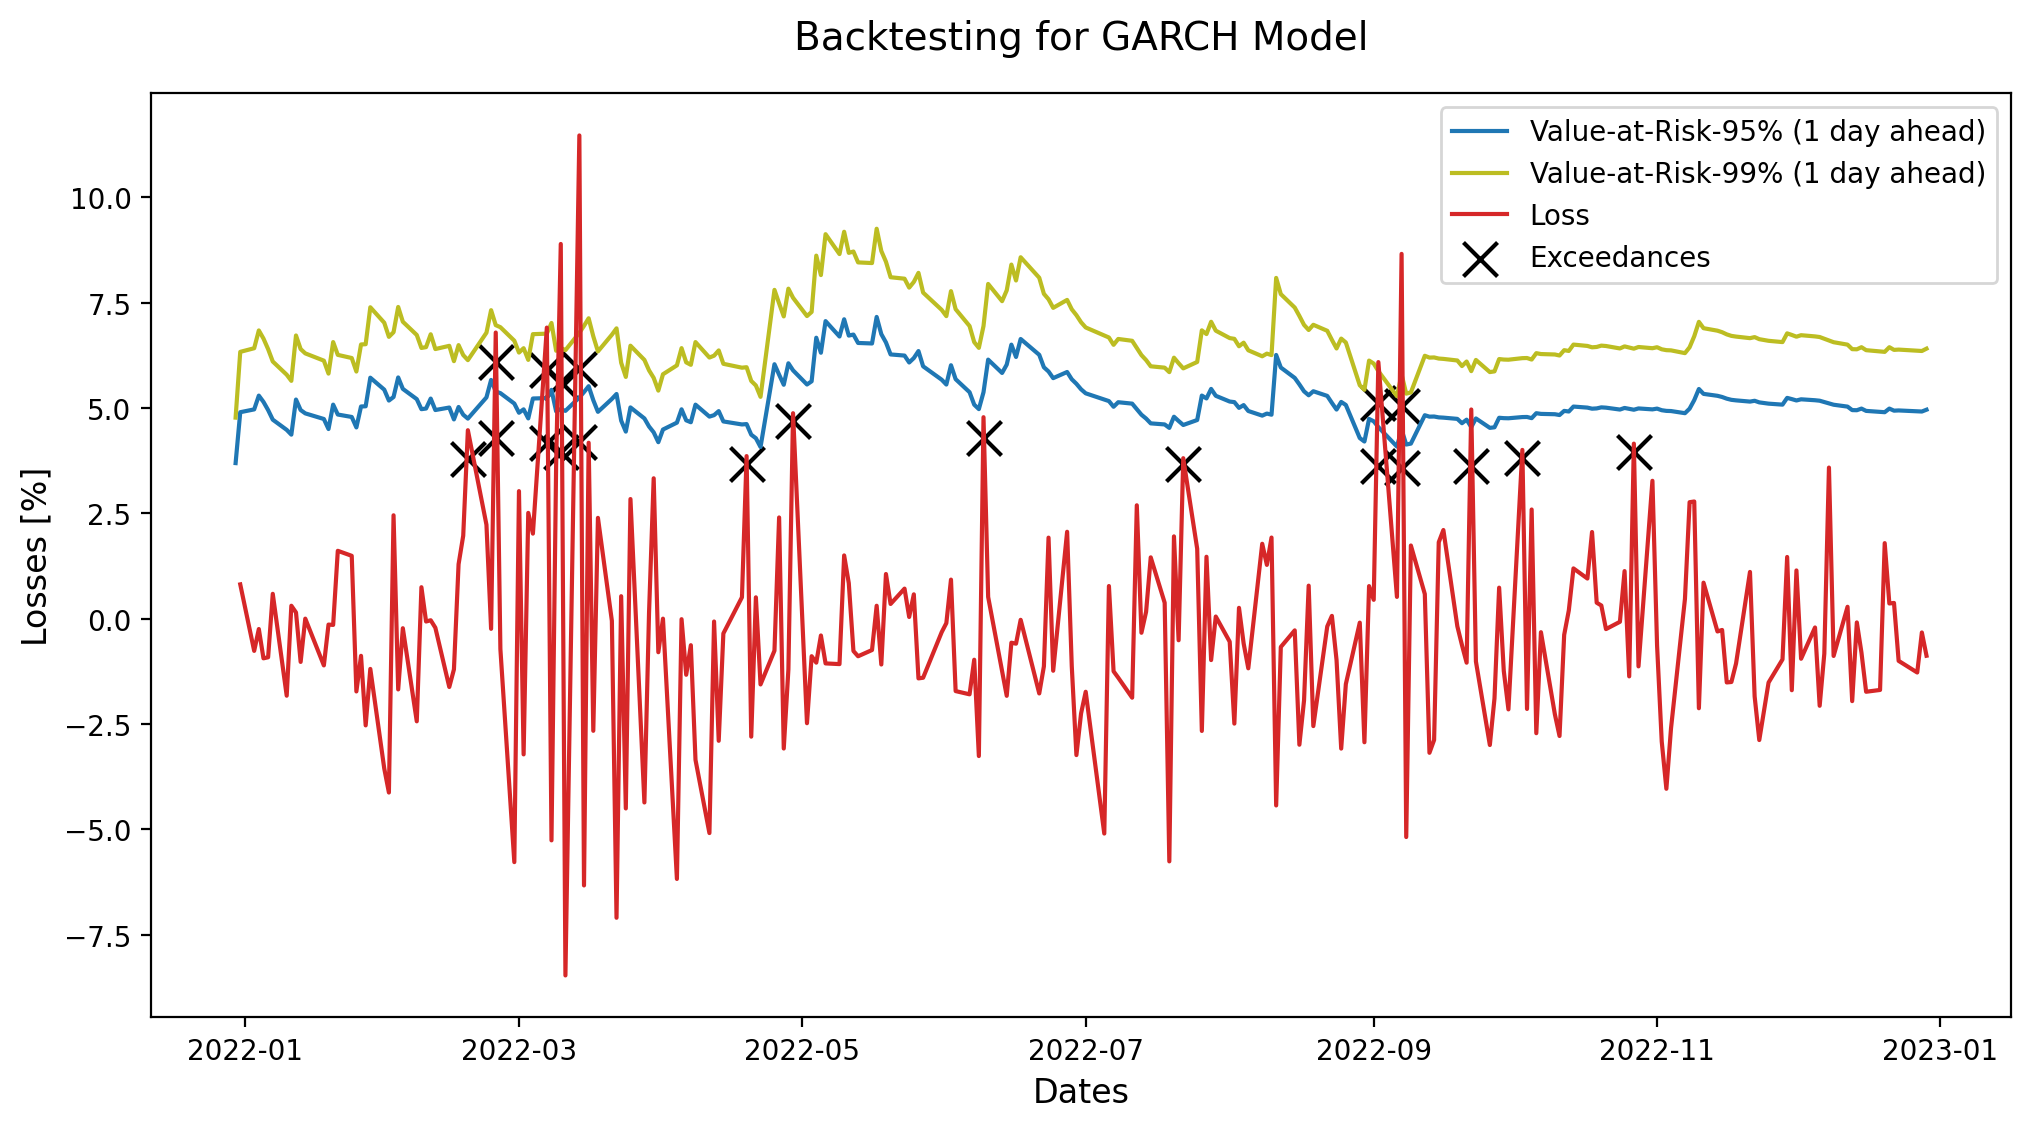

In [32]:
plotter("Backtesting for GARCH Model")

In [33]:
portfolioAtDayN = 100000 # Suppose we invest 100.000$ on day n
days_estimate = 252
testing_period = 252
alpha1 = 0.05 # "We are (1-alpha)% sure that the loss will not exceed .."
alpha2 = 0.01 # "We are (1-alpha)% sure that the loss will not exceed .."

VaR_95_1 = np.zeros(testing_period)
ES_95_1 = np.zeros(testing_period)
VaR_99_1 = np.zeros(testing_period)
ES_99_1 = np.zeros(testing_period)
exceedance_95 = np.zeros(testing_period) 
exceedance_99 = np.zeros(testing_period) 
loss = np.zeros(testing_period)
for i in range(testing_period):

  mean_return = 0 # Assumption
  used_returns = AMZN_returns.values[-(testing_period-i+days_estimate):-(testing_period-i)]
  volatility = np.std(used_returns)
  VaR_95_percentage = -volatility*sps.norm.ppf(alpha1, loc=mean_return, scale=1)/100
  VaR_95 = portfolioAtDayN*VaR_95_percentage
  ES_95_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)))/alpha1)/100
  ES_95 = portfolioAtDayN*ES_95_percentage
  VaR_99_percentage = -volatility*sps.norm.ppf(alpha2, loc=mean_return, scale=1)/100
  VaR_99 = portfolioAtDayN*VaR_99_percentage
  ES_99_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)))/alpha2)/100
  ES_99 = portfolioAtDayN*ES_99_percentage
  VaR_95_1[i] = VaR_95
  ES_95_1[i] = ES_95
  VaR_99_1[i] = VaR_99
  ES_99_1[i] = ES_99
    
  loss[i] = -portfolioAtDayN*AMZN_returns.values[-(testing_period-i)]/100
  exceedance_95[i] = VaR_95 < loss[i]
  exceedance_99[i] = VaR_99 < loss[i]
  
# The final VaR estimate (that we cannot test before seing another realisation of data). Coincides with the number calculated in 4)   
mean_return = 0 # Assumption
used_returns = AMZN_returns.values[-(days_estimate):]
volatility = np.std(used_returns)
VaR_95_percentage = -volatility*sps.norm.ppf(alpha1, loc=mean_return, scale=1)/100
VaR_95 = portfolioAtDayN*VaR_95_percentage
ES_95_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)))/alpha1)/100
ES_95 = portfolioAtDayN*ES_95_percentage
VaR_99_percentage = -volatility*sps.norm.ppf(alpha2, loc=mean_return, scale=1)/100
VaR_99 = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = (volatility*(sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)))/alpha2)/100
ES_99 = portfolioAtDayN*ES_99_percentage


NameError: name 'AMZN_returns' is not defined